In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json

from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



import shutil
from utils.kernels import *
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import ConcatDataset
from torchvision.models import efficientnet_v2_s, resnet50, ResNet50_Weights, googlenet, efficientnet_b0, mobilenet_v3_large
from utils.eval import evaluate, validation_and_agreement, distance_models, validation_agreement_function_distance
from dataset_utils.data_utils import load_dataset, CIFAR100sparse2coarse



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Feature kernel calculation

In [31]:
def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n,n))/n 
    return np.matmul(K,H)

In [4]:
def plot_matrix(M, title, size=(8,10)):
    fig, ax = plt.subplots(figsize=size)
    mat = ax.matshow(M)
    ax.set_title(title,fontsize=20)
    ax.tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
    ax.tick_params(axis='y', colors='black', bottom=True, top=False)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)

    plt.show()
    return fig

In [5]:
GPUID = 5
#os.environ["CUDA_VISIBLE_DEVICES"]=str(GPUID)
device = get_device([GPUID])

In [6]:
#device='cpu'

### IMAGENET

In [42]:
NUM_SAMPLES = 500000
NUM_BATCHES = 10

In [43]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', inference_transform)
all_indices = set(range(len(train_dataset)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(train_dataset, random_indices)
loader = DataLoader(data, batch_size=128, shuffle=False, num_workers=4, pin_memory=False)


In [44]:

def load_checkpoint(best=False, filename='checkpoint.pth.tar', student=False):
    path = base_path() + "chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)  
          if not student: 
              new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
              checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [45]:
# initialising the model
teacher =  resnet50(weights=None)
teacher = feature_wrapper(teacher)

CHKPT_NAME = 'rn50_2023-02-21_10-45-30_best.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50_2023-02-21_10-45-30_best.ckpt


In [46]:
KT = compute_empirical_kernel(loader, teacher, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:26 ] Task Collecting features | epoch -1: |┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 4.39 ep/h | loss: 0.9 |

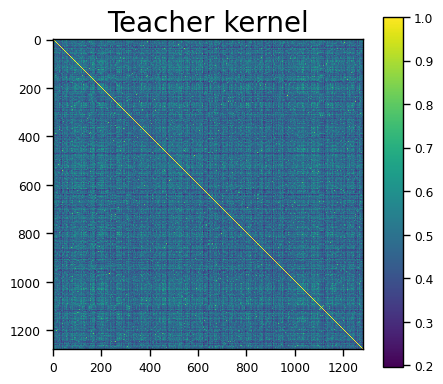

In [47]:
plot_matrix(KT, r'Teacher kernel', size=(4,5));

In [48]:
# initialising the model
student =  resnet50(weights=None)
student = feature_wrapper(student)

CHKPT_NAME = 'rn50-student-11-90000-0.0.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-90000-0.0.ckpt


In [49]:
KS0 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:26 ] Task Collecting features | epoch -1: |┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 4.49 ep/h | loss: 0.9 |

In [50]:
# initialising the model
student =  resnet50(weights=None)
student = feature_wrapper(student)

CHKPT_NAME = 'rn50-student-11-90000-1.0.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, student=False) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-90000-1.0.ckpt


In [51]:
KS1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:26 ] Task Collecting features | epoch -1: |┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 4.54 ep/h | loss: 0.9 |

In [52]:
centered_kernal_alignment(KS0,KT)

0.896233661871349

In [53]:
centered_kernal_alignment(KS1,KT)

0.6429021665509607

In [54]:
KT_c = center_kernel(KT)
KS0_c = center_kernel(KS0)
KS1_c = center_kernel(KS1)

In [55]:
spectrum_T = np.linalg.eigvals(KT)

In [56]:
spectrum_S0 = np.linalg.eigvals(KS0)

In [57]:
spectrum_S1 = np.linalg.eigvals(KS1)

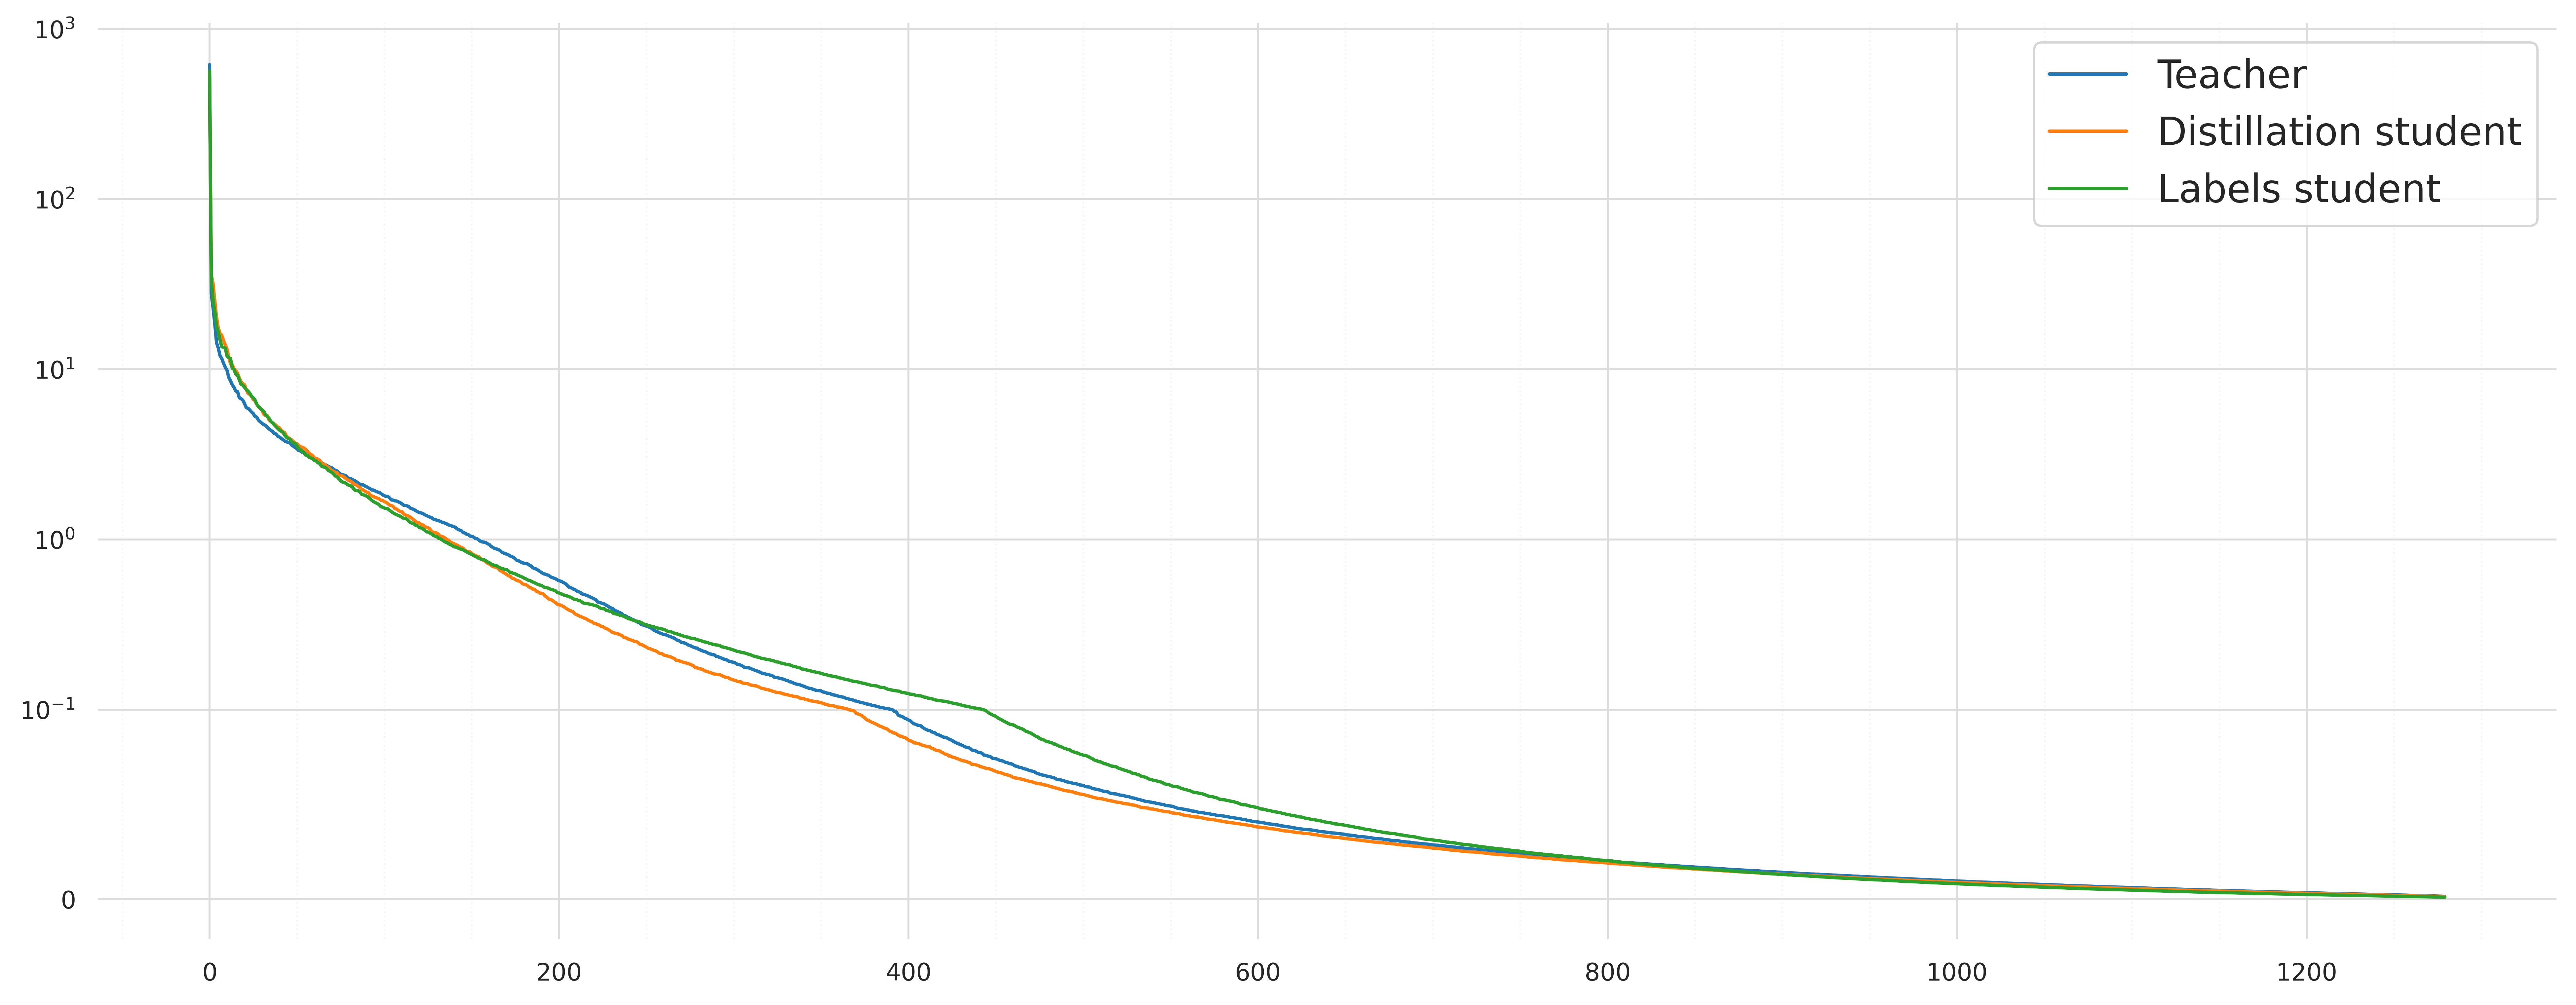

In [59]:
# Show the results for the first time series and its subseries
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(16,6), sharey=True, dpi=600)
    i = range(len(spectrum_T))
    plt.plot(np.flip(np.sort(spectrum_T)), '-', label='Teacher', ms=0.5)

    plt.plot(np.flip(np.sort(spectrum_S0)), '-', label='Distillation student')
    plt.plot(np.flip(np.sort(spectrum_S1)), '-', label='Labels student')

    ax.set_yscale('symlog',linthresh=10e-2)
    #x.set_xscale('symlog',linthresh=10e-2)
    
    #ax.set_ylim([0.0,1.0])

    #ax.set_xlim([0,1000])

    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=14)


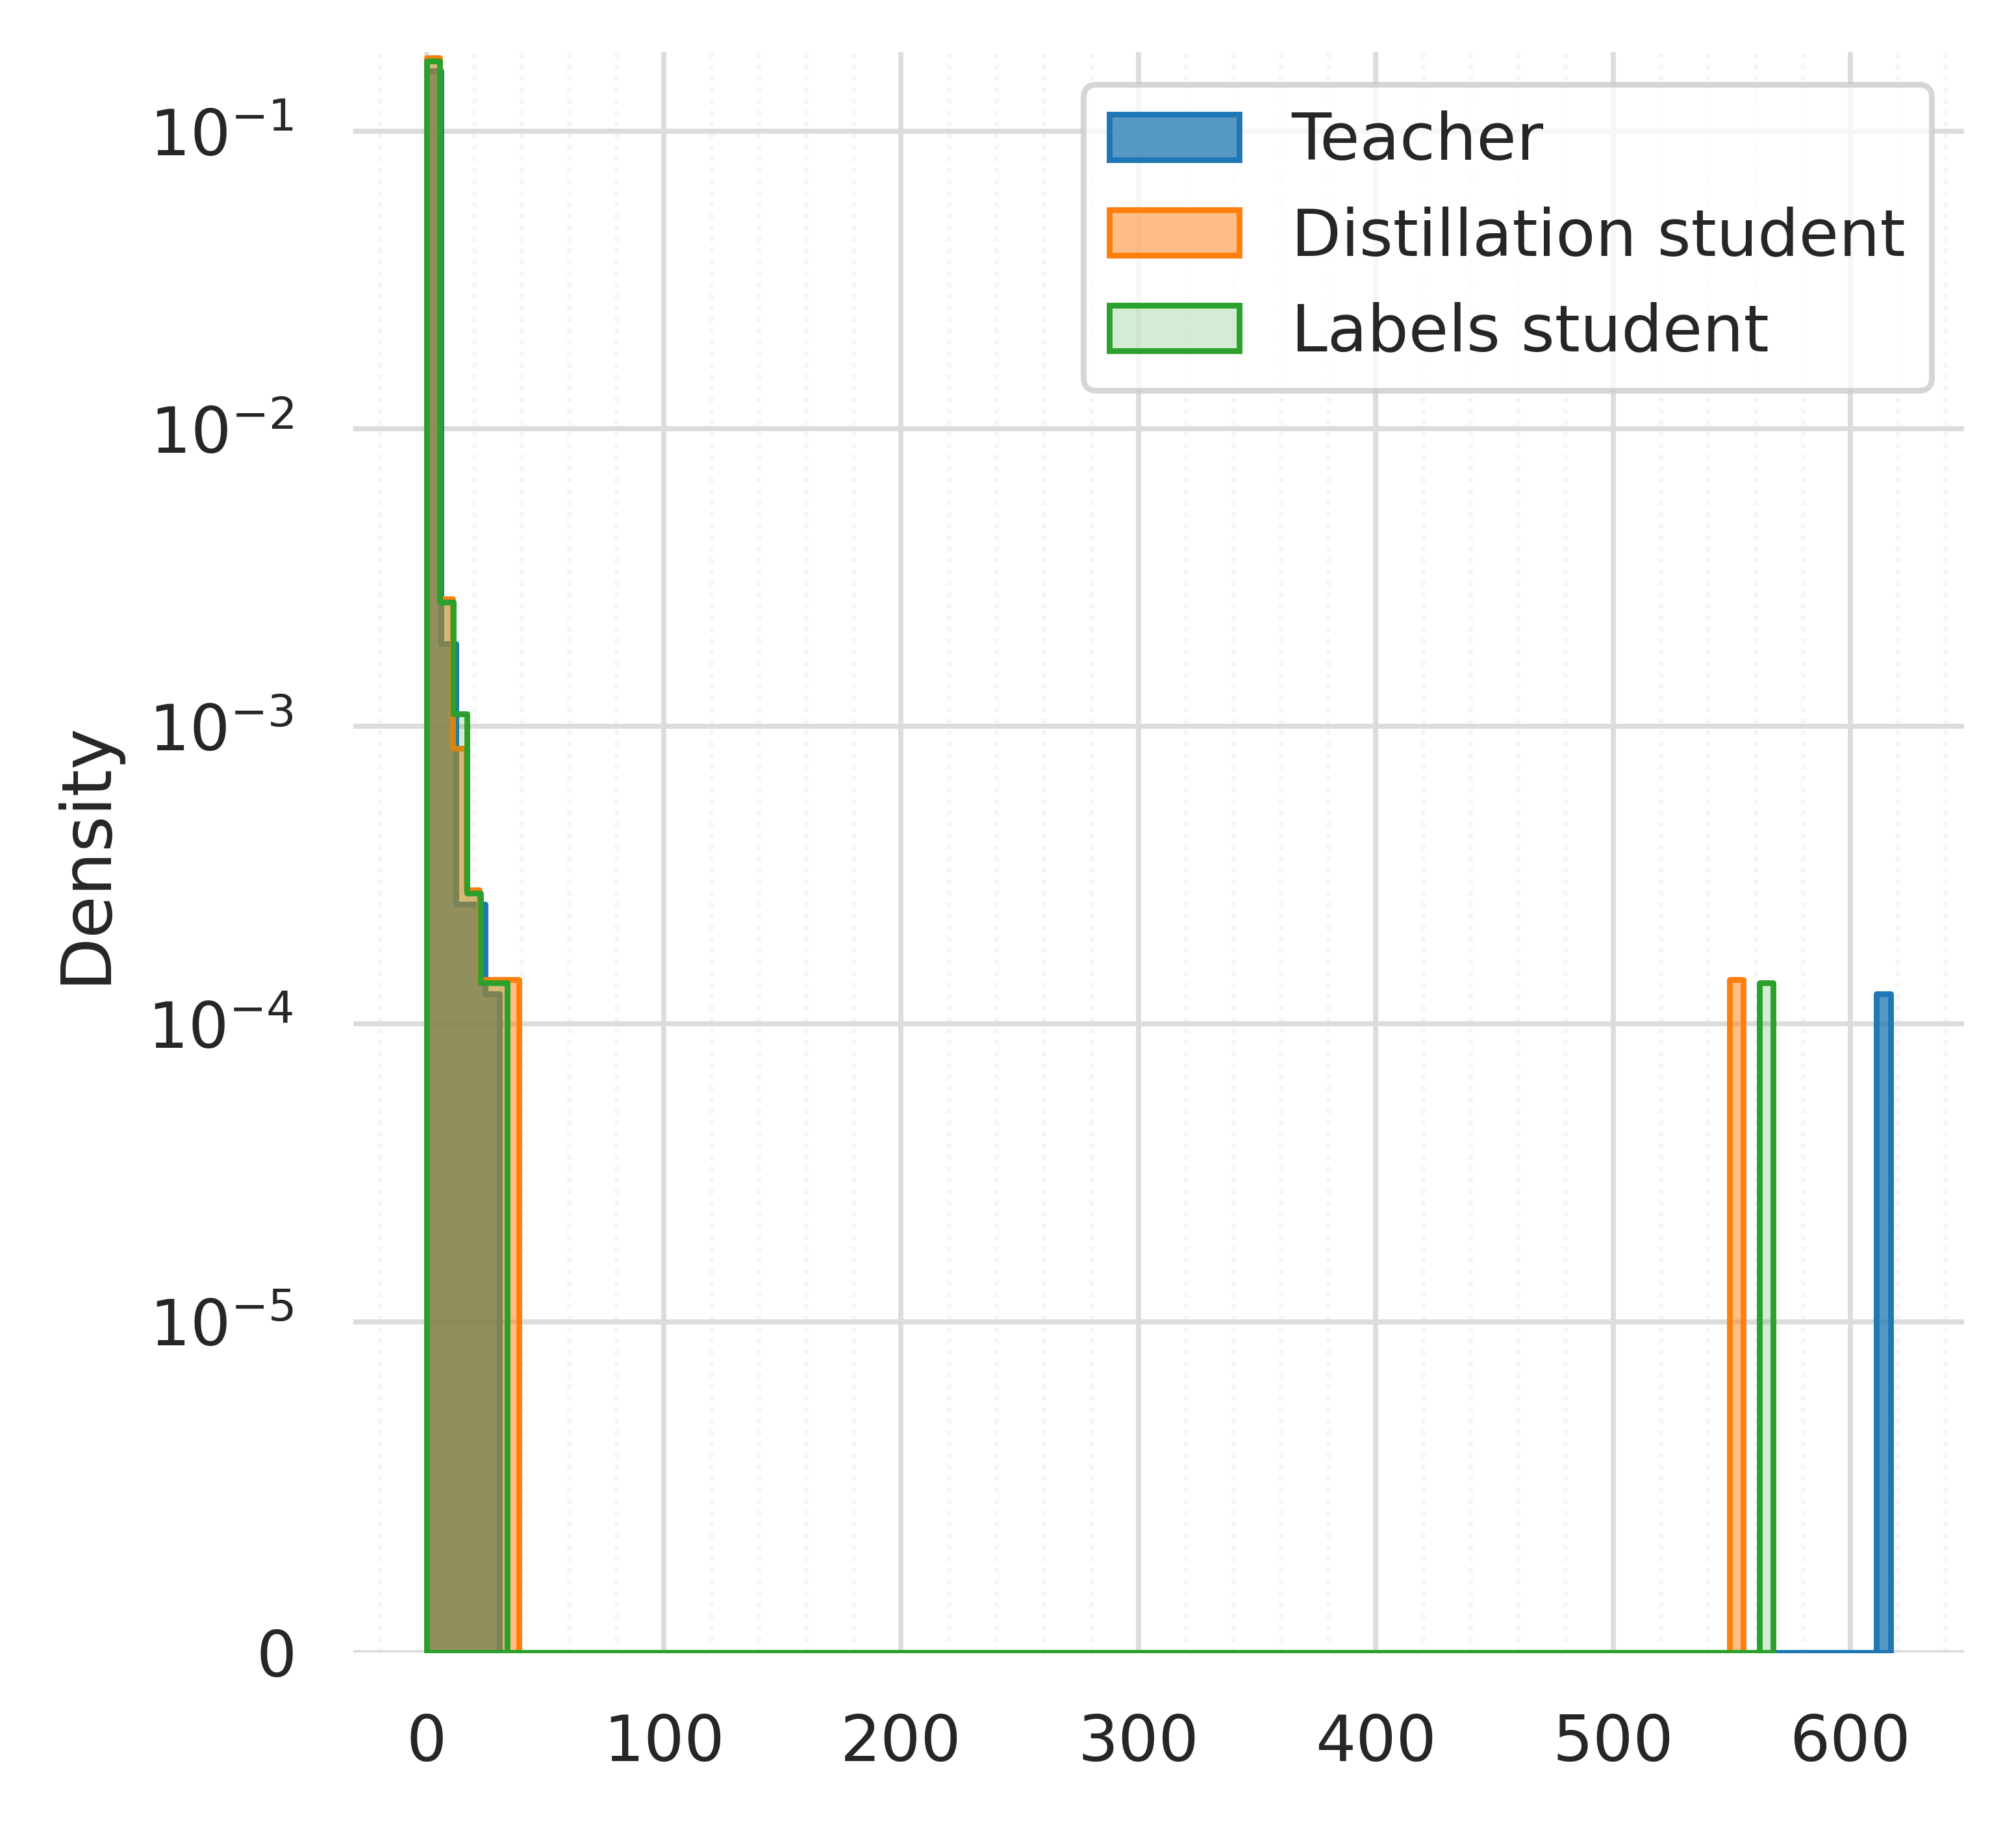

In [60]:
# Show the results for the first time series and its subseries
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(4,4), sharey=True, dpi=800)

    x = range(len(spectrum_T))
    sns.histplot(spectrum_T, label='Teacher',   bins=100, ax=ax,  fill=True, element="step", stat="density")
    sns.histplot(spectrum_S0, label='Distillation student',  alpha=0.5, bins=100, ax=ax,  fill=True, element="step",
    stat="density")
    sns.histplot(spectrum_S1, label='Labels student',  alpha=0.2, bins=100, ax=ax,  fill=True, element="step",
    stat="density")

    ax.set_yscale('symlog',linthresh=10e-6)
    #ax.set_xscale('symlog',linthresh=10e1)
    
    #ax.set_ylim([0.0,1.0])

    #ax.set_xlim([600,800])

    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=9)


### CIFAR 5M

In [61]:
NUM_SAMPLES = 500000

In [62]:

C5m_train, C5m_test = load_dataset('cifar5m', augment=False)

print(f"Randomly drawing {NUM_SAMPLES} samples for the Cifar5M base")
all_indices = set(range(len(C5m_train)))
random_indices = np.random.choice(list(all_indices), size=NUM_SAMPLES, replace=False)
data = Subset(C5m_train, random_indices)

Loading CIFAR 5mil...
Loaded part 1/6
Loaded part 2/6
Loaded part 3/6
Loaded part 4/6
Loaded part 5/6
Loaded part 6/6
Randomly drawing 500000 samples for the Cifar5M base


In [75]:
loader = DataLoader(data, batch_size=128, shuffle=False, num_workers=4, pin_memory=False)

In [63]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', type='mnet'):
    """ Available network types: [mnet, convnet]"""
    path = base_path() + "chkpts" + "/" + "cifar5m" + "/" + f"{type}/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 


In [65]:
# ENTROPY = 0.35
teacher = CNN(num_classes=10, c=20) # adjusting for CIFAR 
CHKPT_NAME = f'CNN-teacher.ckpt' 

In [66]:
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME, type='CNN') 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar5m/CNN/CNN-teacher.ckpt


In [76]:
KT = compute_empirical_kernel(loader, teacher, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:33 ] Task Collecting features | epoch -1: |┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 121.9 ep/h | loss: 0.9 ||

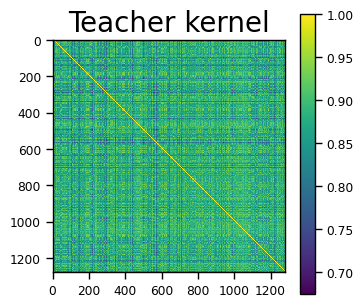

In [77]:
plot_matrix(KT, r'Teacher kernel', size=(3,4));

Loading the students and computing kernels

In [78]:
student = CNN(num_classes=10, c=20) 
alpha = 0.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'CNN-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME, type='CNN') 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar5m/CNN/CNN-student-13-24000-0.0.ckpt


In [79]:
KS0 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:33 ] Task Collecting features | epoch -1: |┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 122.14 ep/h | loss: 0.9 |

In [80]:
student = CNN(num_classes=10, c=20) 
alpha = 1.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'CNN-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME, type='CNN') 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar5m/CNN/CNN-student-13-24000-1.0.ckpt


In [81]:
KS1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:33 ] Task Collecting features | epoch -1: |┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 113.44 ep/h | loss: 0.9 |

In [82]:
centered_kernal_alignment(KS0,KT)

0.9247176761120525

In [83]:
centered_kernal_alignment(KS1,KT)

0.8675849260452138

In [84]:
KT_c = center_kernel(KT)
KS0_c = center_kernel(KS0)
KS1_c = center_kernel(KS1)

In [85]:
spectrum_T = np.linalg.eigvals(KT_c)

In [86]:
spectrum_S0 = np.linalg.eigvals(KS0_c)

In [87]:
spectrum_S1 = np.linalg.eigvals(KS1_c)

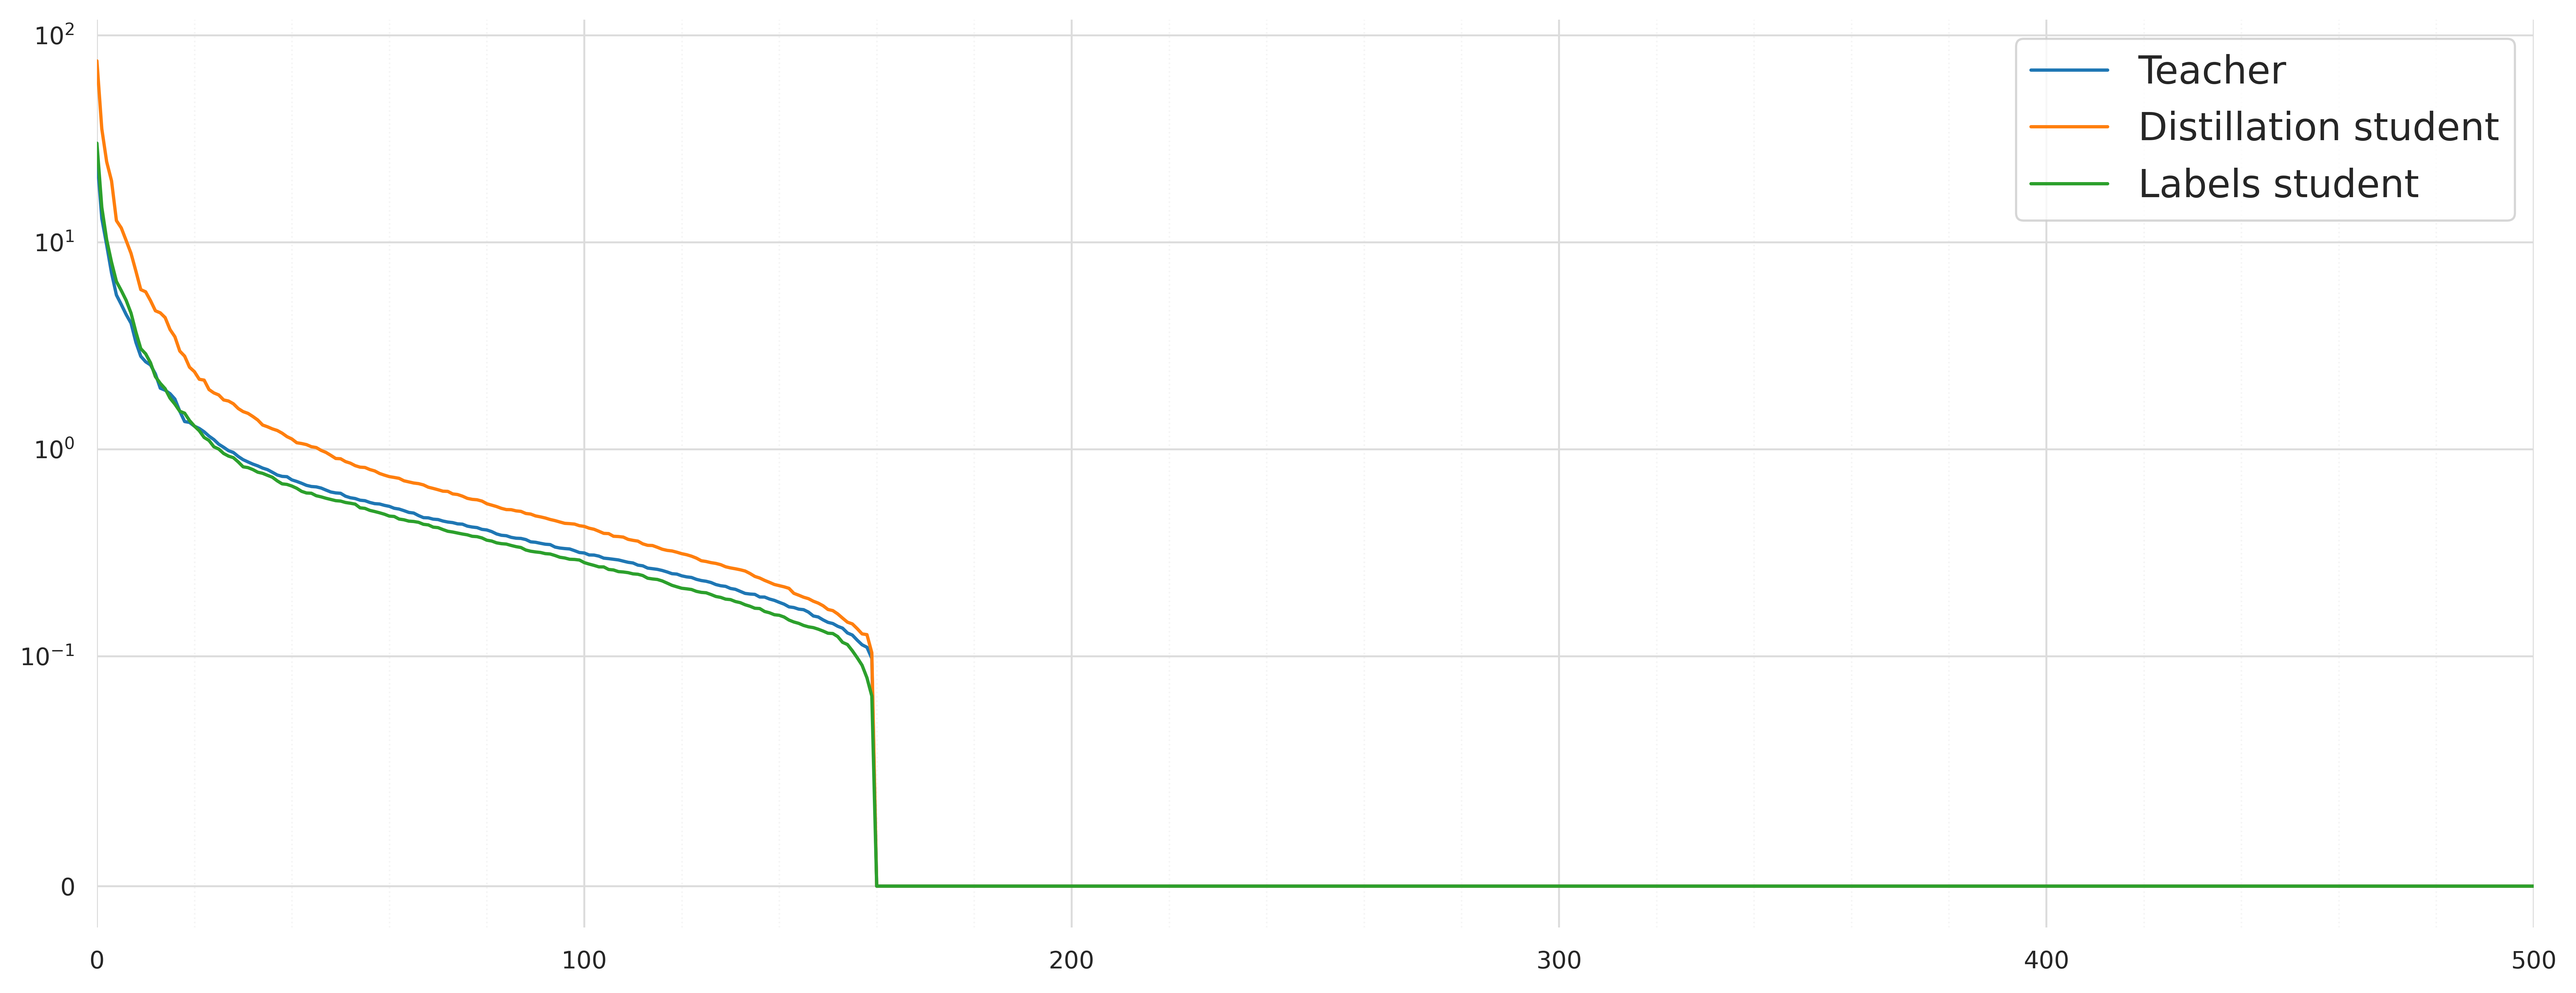

In [89]:
# Show the results for the first time series and its subseries
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(16,6), sharey=True, dpi=600)
    i = range(len(spectrum_T))
    plt.plot(np.flip(np.sort(spectrum_T)), '-', label='Teacher', ms=0.5)

    plt.plot(np.flip(np.sort(spectrum_S0)), '-', label='Distillation student')
    plt.plot(np.flip(np.sort(spectrum_S1)), '-', label='Labels student')

    ax.set_yscale('symlog',linthresh=10e-2)
    #x.set_xscale('symlog',linthresh=10e-2)
    
    #ax.set_ylim([0.0,1.0])

    ax.set_xlim([0,500])

    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=14)


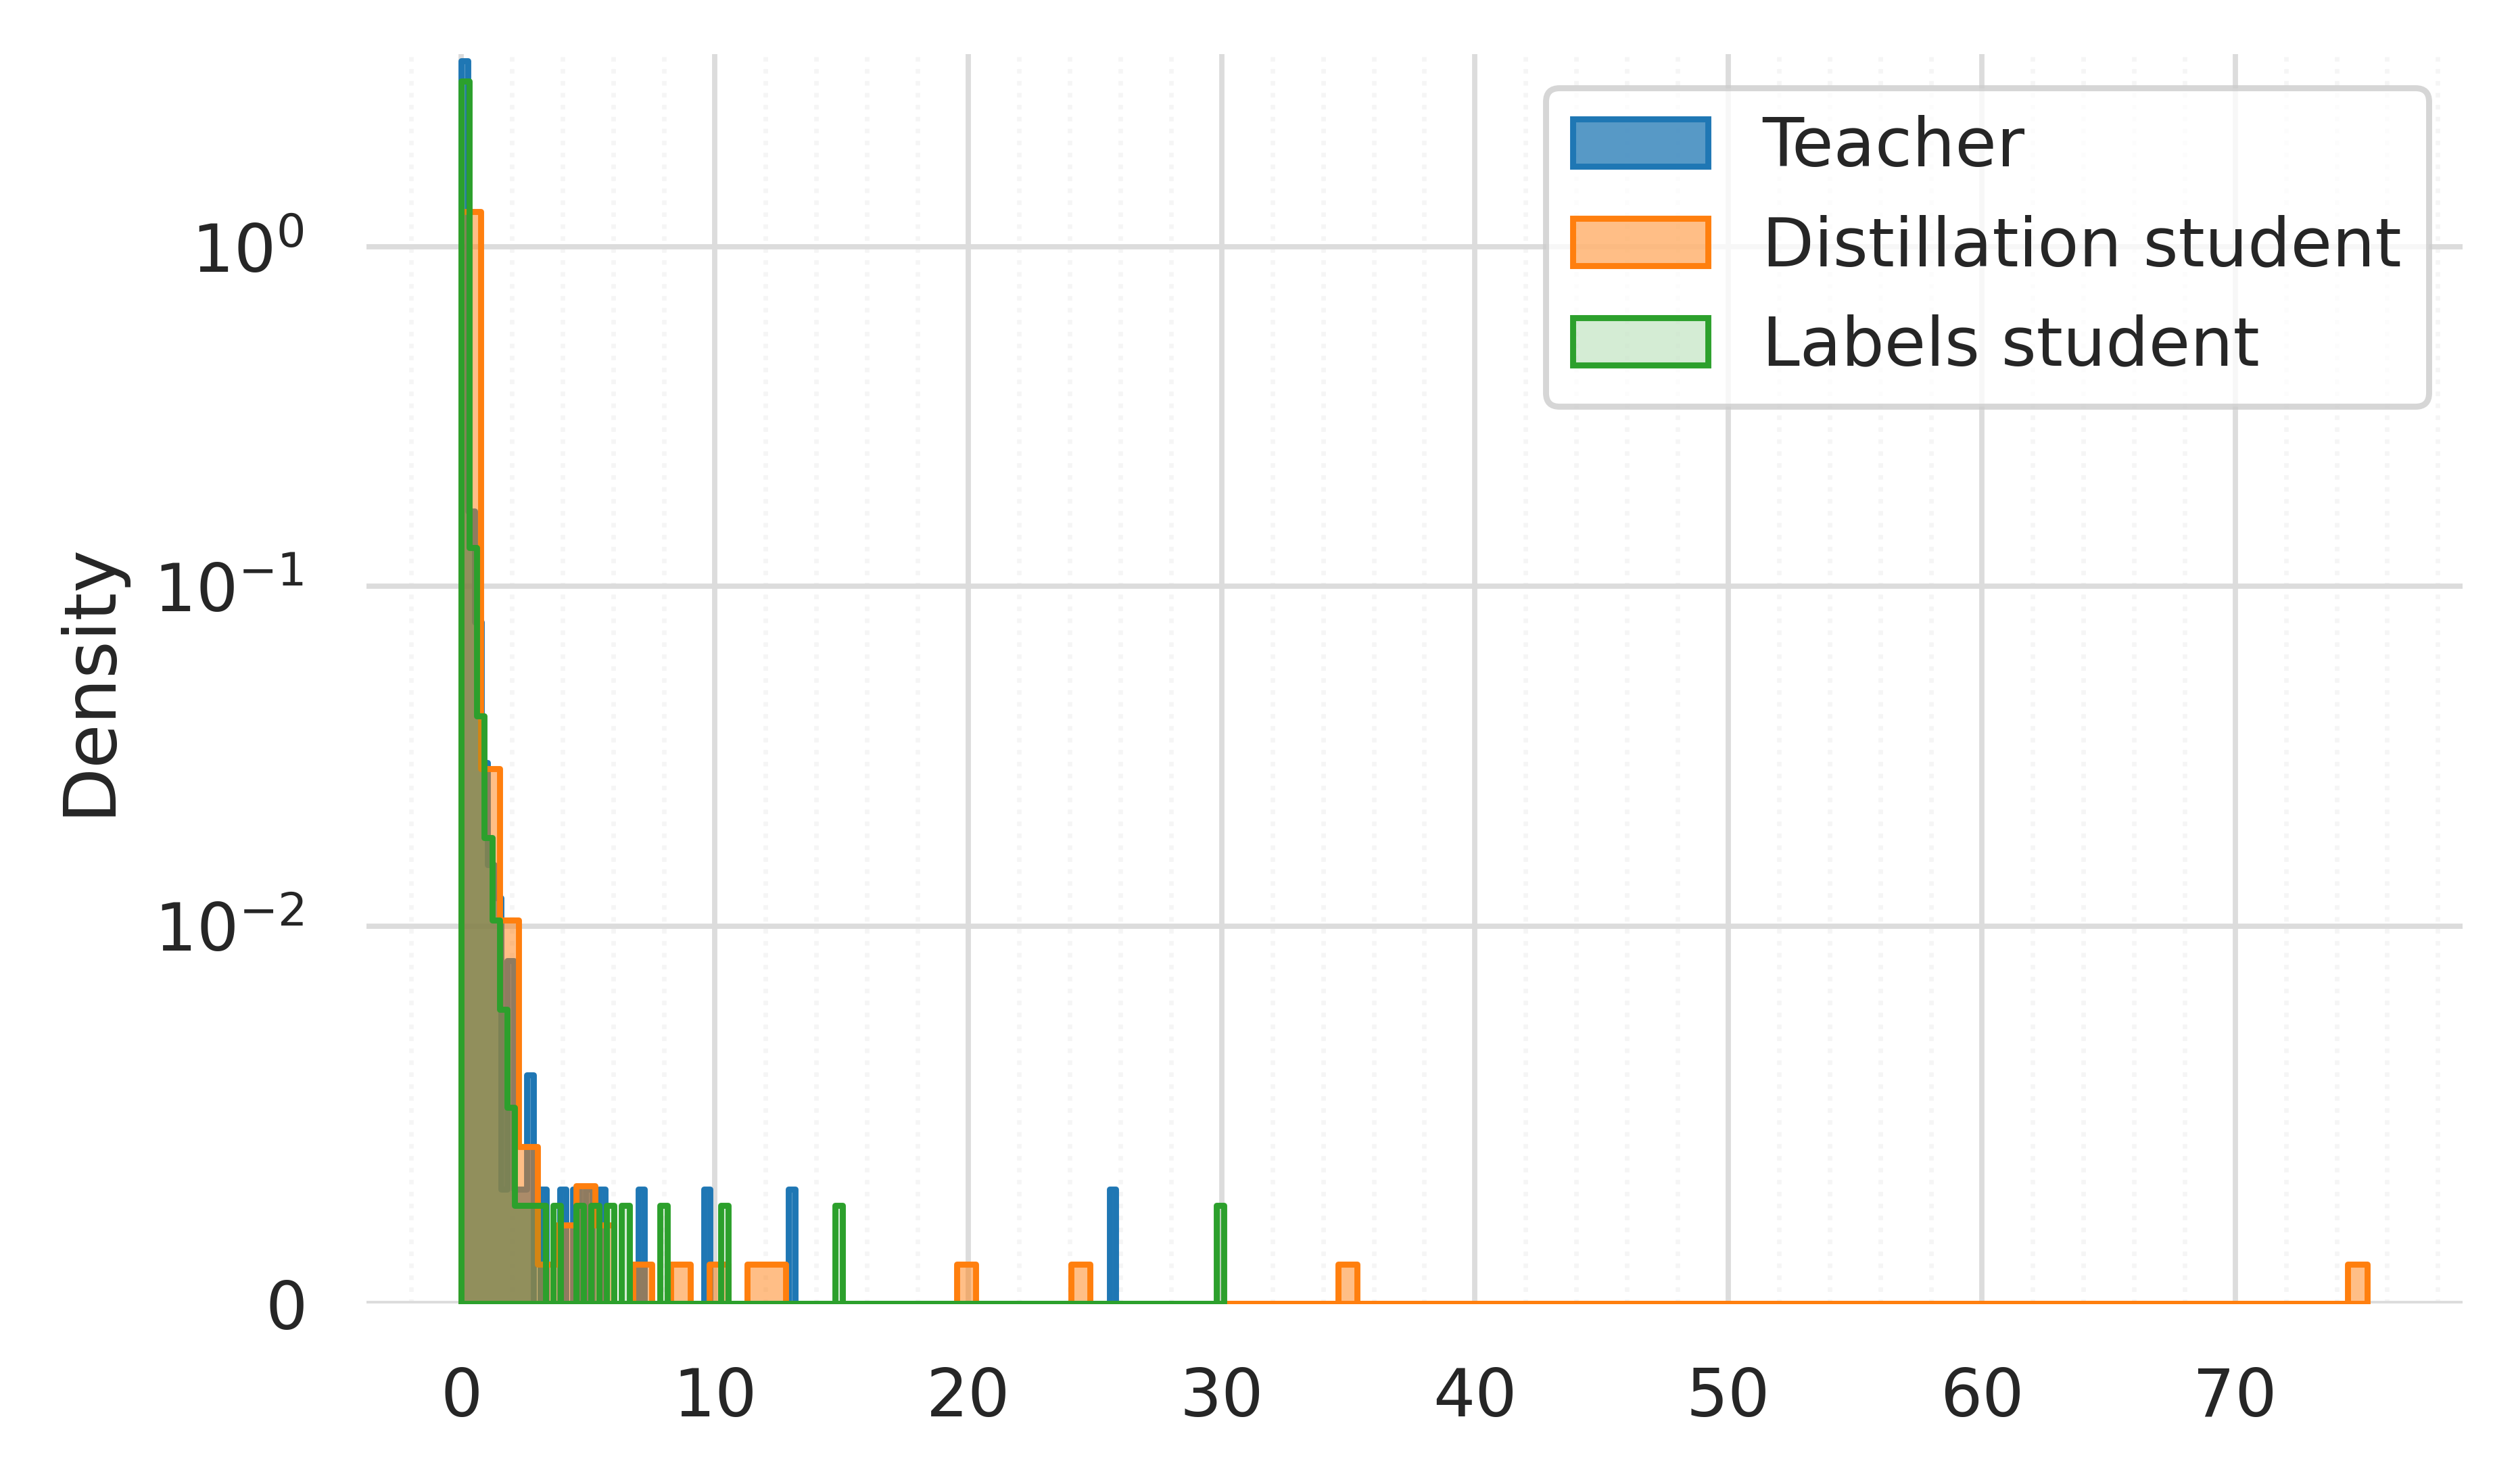

In [90]:
# Show the results for the first time series and its subseries
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)

    x = range(len(spectrum_T))
    sns.histplot(spectrum_T, label='Teacher',   bins=100, ax=ax,  fill=True, element="step", stat="density")
    sns.histplot(spectrum_S0, label='Distillation student',  alpha=0.5, bins=100, ax=ax,  fill=True, element="step",
    stat="density")
    sns.histplot(spectrum_S1, label='Labels student',  alpha=0.2, bins=100, ax=ax,  fill=True, element="step",
    stat="density")

    ax.set_yscale('symlog',linthresh=10e-3)
    #ax.set_xscale('symlog',linthresh=10e1)
    
    #ax.set_ylim([0.0,1.0])

    #ax.set_xlim([600,800])

    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=9)


### CIFAR 100

In [17]:
NUM_BATCHES=30

In [18]:

C100_train, C100_val = load_dataset('cifar100', augment=False)
all_data = ConcatDataset([C100_train, C100_val])
shuffled_train = torch.utils.data.Subset(C100_train, torch.randperm(len(C100_train)).tolist())
loader = DataLoader(shuffled_train, batch_size=128, shuffle=False, num_workers=4, pin_memory=False)

In [19]:
len(loader)

391

In [20]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "chkpts" + "/" + "cifar100" + "/" + "resnet18/"
    if best: filepath = path + 'model_best.ckpt'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          return checkpoint
    return None 

Loading the teacher and computing the kernel

In [22]:
# initialising the model
teacher = resnet18(num_classes=100)
#teacher = make_cnn(c=150, num_classes=100, use_batch_norm=True)
CHKPT_NAME = 'resnet18-teacher.ckpt'
#CHKPT_NAME = 'convnet150-teacher.ckpt'
checkpoint = load_checkpoint(best=False, filename=CHKPT_NAME) 
if checkpoint: 
        teacher.load_state_dict(checkpoint['state_dict'])
        teacher.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-teacher.ckpt


In [23]:
KT = compute_empirical_kernel(loader, teacher, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:21 ] Task Collecting features | epoch -1: |███┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 383.15 ep/h | loss: 0.96666667 |

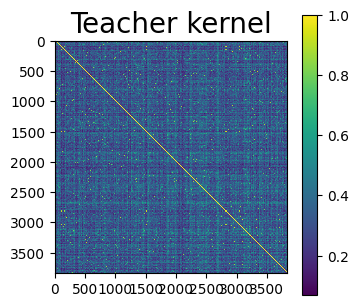

In [24]:
plot_matrix(KT, r'Teacher kernel', size=(3,4));

Loading the students and computing kernels

In [25]:
student = resnet18(num_classes=100)
alpha = 0.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


In [26]:
KS0 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:21 ] Task Collecting features | epoch -1: |███┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 390.73 ep/h | loss: 0.96666667 |

In [27]:
student = resnet18(num_classes=100)
alpha = 1.0
buffer_size = 24000
seed = 13
STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
if checkpoint: 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


In [28]:
KS1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

[ 12-13 | 17:21 ] Task Collecting features | epoch -1: |███┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 384.19 ep/h | loss: 0.96666667 |

In [35]:
centered_kernal_alignment(KS0,KT)

0.8381190534897333

In [30]:
centered_kernal_alignment(KS1,KT)

0.6629038692364322

In [33]:
KT_c = center_kernel(KT)
KS0_c = center_kernel(KS0)
KS1_c = center_kernel(KS1)

In [36]:
spectrum_T = np.linalg.eigvals(KT_c)

In [37]:
spectrum_S0 = np.linalg.eigvals(KS0_c)

In [38]:
spectrum_S1 = np.linalg.eigvals(KS1_c)

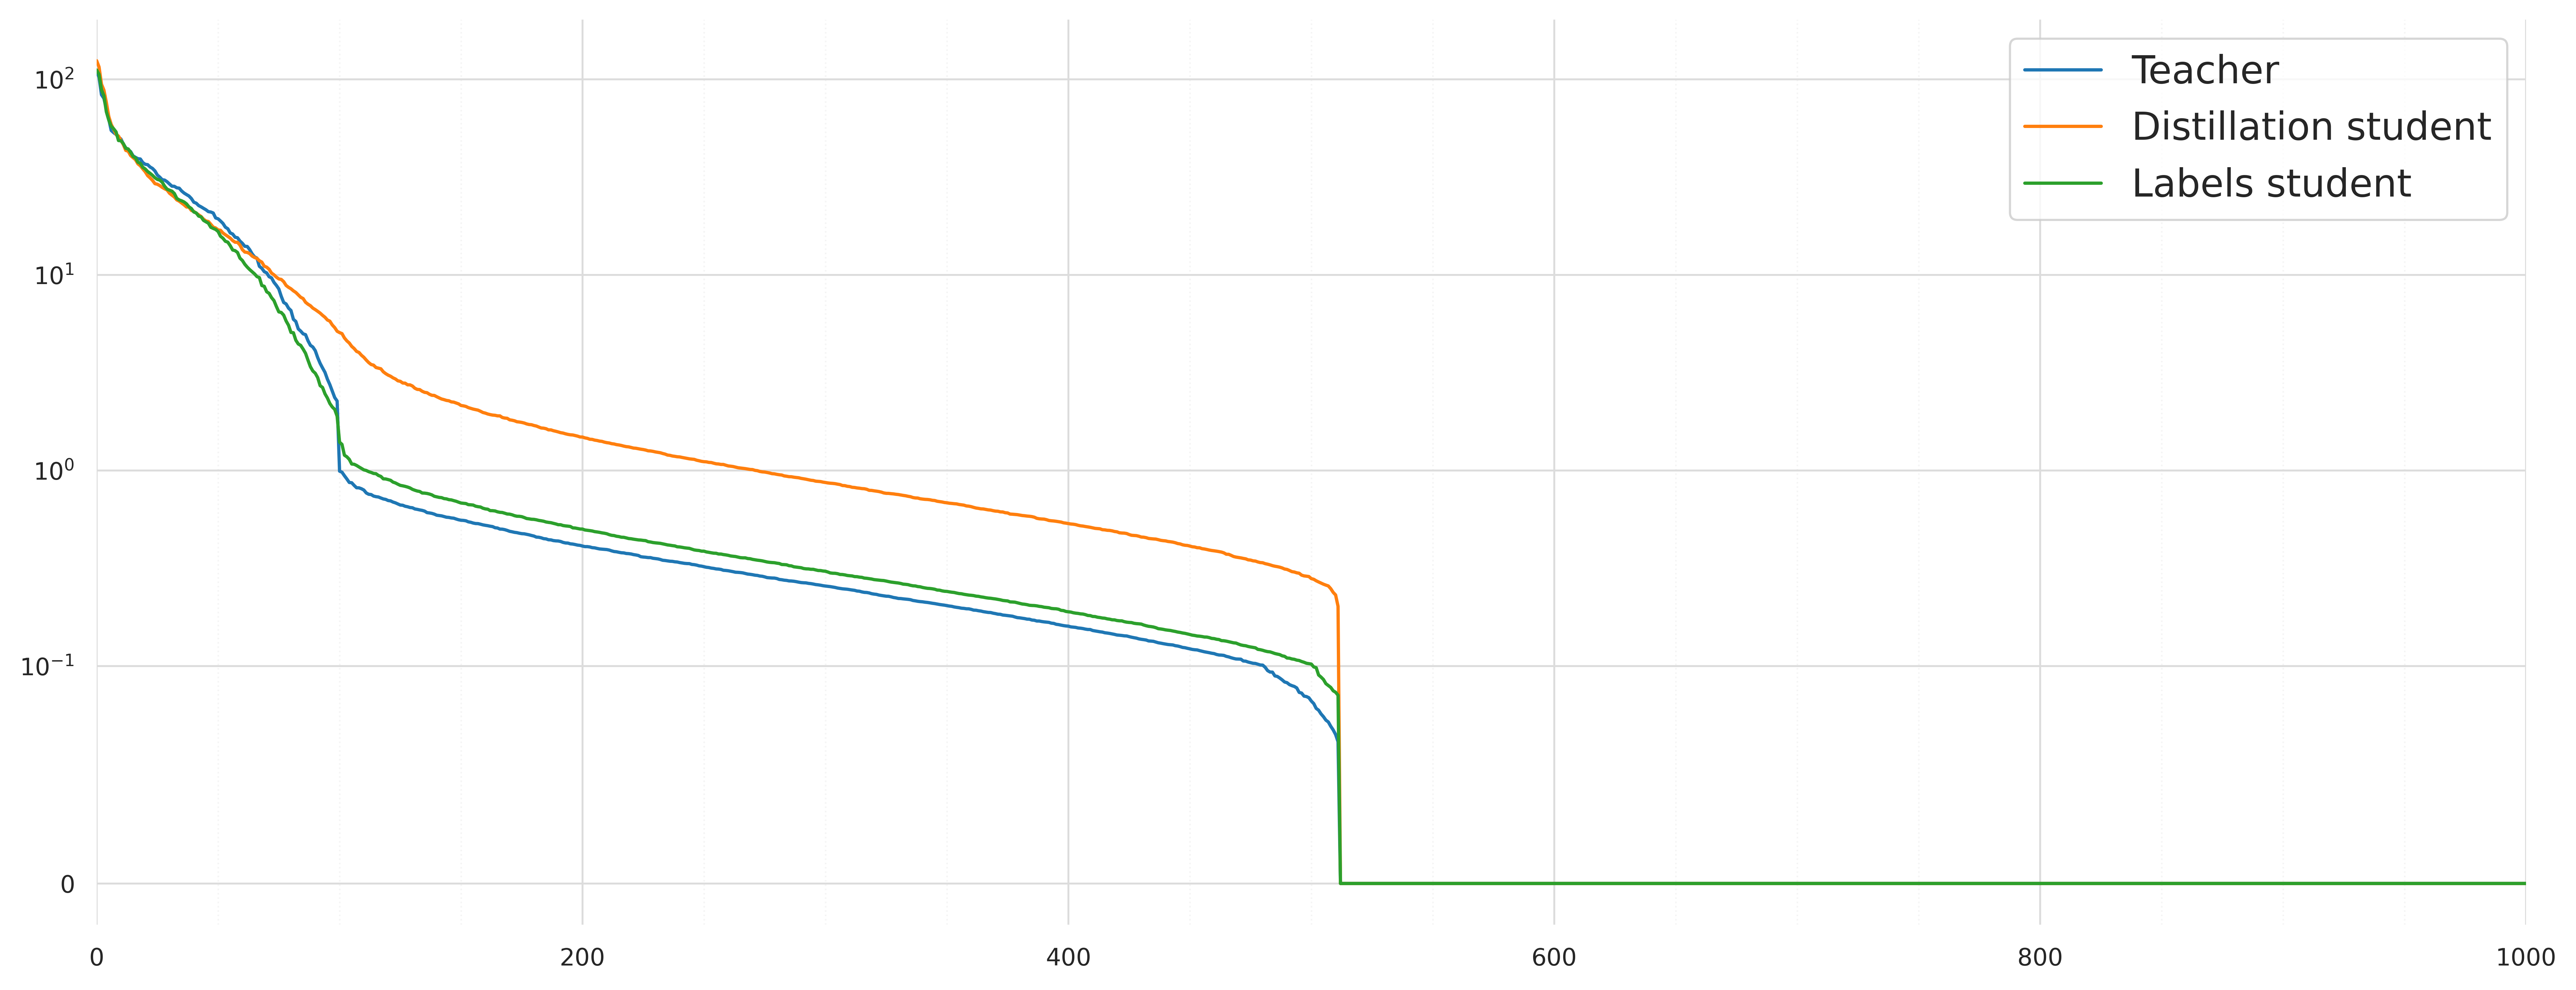

In [39]:
# Show the results for the first time series and its subseries
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(16,6), sharey=True, dpi=600)
    i = range(len(spectrum_T))
    plt.plot(np.flip(np.sort(spectrum_T)), '-', label='Teacher', ms=0.5)

    plt.plot(np.flip(np.sort(spectrum_S0)), '-', label='Distillation student')
    plt.plot(np.flip(np.sort(spectrum_S1)), '-', label='Labels student')

    ax.set_yscale('symlog',linthresh=10e-2)
    #x.set_xscale('symlog',linthresh=10e-2)
    
    #ax.set_ylim([0.0,1.0])

    ax.set_xlim([0,1000])

    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=14)


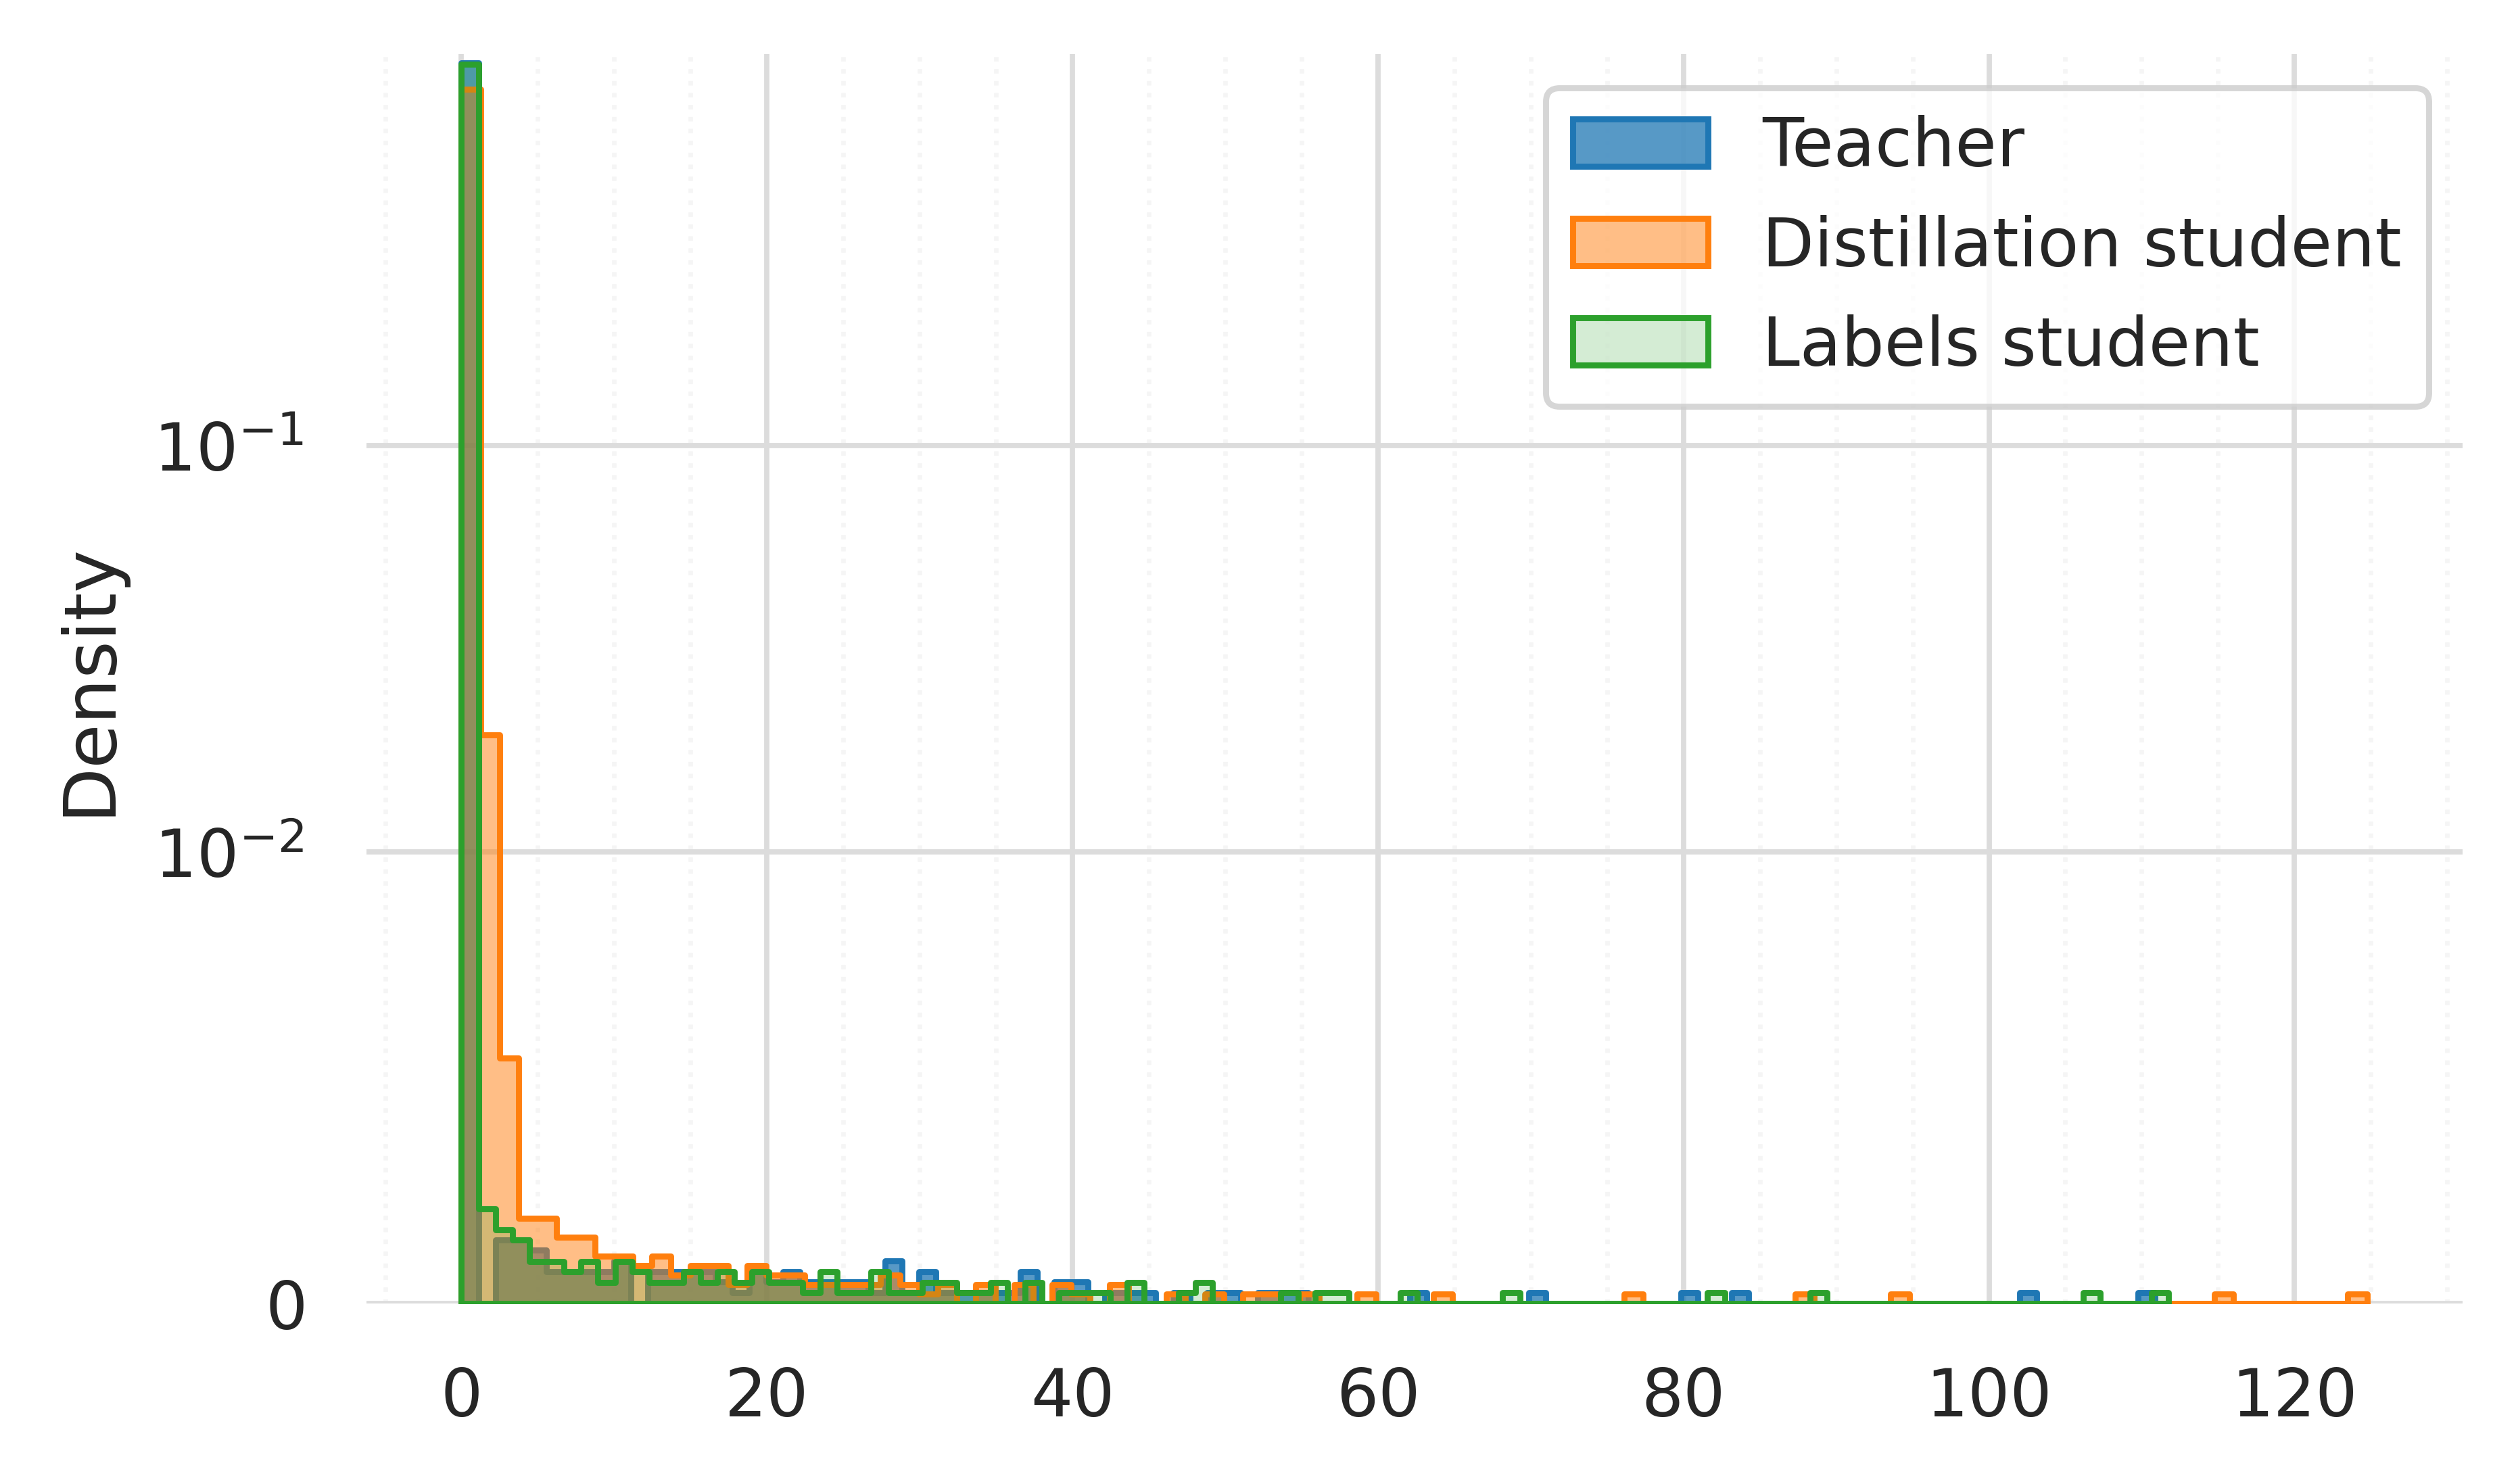

In [41]:
# Show the results for the first time series and its subseries
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)

    x = range(len(spectrum_T))
    sns.histplot(spectrum_T, label='Teacher',   bins=100, ax=ax,  fill=True, element="step", stat="density")
    sns.histplot(spectrum_S0, label='Distillation student',  alpha=0.5, bins=100, ax=ax,  fill=True, element="step",
    stat="density")
    sns.histplot(spectrum_S1, label='Labels student',  alpha=0.2, bins=100, ax=ax,  fill=True, element="step",
    stat="density")

    ax.set_yscale('symlog',linthresh=10e-3)
    #ax.set_xscale('symlog',linthresh=10e1)
    
    #ax.set_ylim([0.0,1.0])

    #ax.set_xlim([600,800])

    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=9)


In [24]:
buffer_size = 24000
alpha = 1.0
alignments_1 = []
for seed in SEEDS:
    student = resnet18(num_classes=100)
    STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
    checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
    if checkpoint: 
            student.load_state_dict(checkpoint['state_dict'])
            student.to(device)
    KS1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
    alignments_1.append(centered_kernal_alignment(KS1,KT))
alignments_1

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 368.98 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.8 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.75 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:44 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 371.75 ep/h | loss: 0.9 |

[0.6768327489108363,
 0.6756104273978195,
 0.6808177522061001,
 0.6772146930234169,
 0.6816759064969254]

In [25]:
buffer_size = 24000
alpha = 0.0
alignments_0 = []
for seed in SEEDS:
    student = resnet18(num_classes=100)
    STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
    checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
    if checkpoint: 
            student.load_state_dict(checkpoint['state_dict'])
            student.to(device)
    KS1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
    alignments_0.append(centered_kernal_alignment(KS1,KT))
alignments_0

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 383.24 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.63 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.99 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 390.82 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:45 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 389.95 ep/h | loss: 0.9 |

[0.8321372182313193,
 0.8458086408606634,
 0.8461684980740904,
 0.8474502475276462,
 0.8478838172534987]

In [27]:
buffer_size = 24000
alpha = 0.0
A00 = np.zeros((len(SEEDS),len(SEEDS)))
for i,seed in enumerate(SEEDS):
    for j,seed2 in enumerate(SEEDS):
        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed2}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K2 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
        A00[i,j] = centered_kernal_alignment(K1,K2)
A00

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 372.03 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.72 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.11 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.86 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.24 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.47 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.16 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.33 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 420.25 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.77 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.62 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.3 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.75 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.86 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.92 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 389.61 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.02 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.19 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.81 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.79 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.57 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.73 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.97 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.52 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.08 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.46 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:48 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.08 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.28 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.73 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.35 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 401.32 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.92 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 403.52 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 399.59 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.99 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.31 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.64 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.25 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.52 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.19 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.99 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.83 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.62 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.83 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-0.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.06 ep/h | loss: 0.9 |

array([[1.        , 0.88291069, 0.88322573, 0.88418155, 0.88176088],
       [0.88291069, 1.        , 0.88810322, 0.88977001, 0.89226183],
       [0.88322573, 0.88810322, 1.        , 0.88975531, 0.88728097],
       [0.88418155, 0.88977001, 0.88975531, 1.        , 0.8903652 ],
       [0.88176088, 0.89226183, 0.88728097, 0.8903652 , 1.        ]])

In [28]:
buffer_size = 24000
alpha = 1.0
A11 = np.zeros((len(SEEDS),len(SEEDS)))
for i,seed in enumerate(SEEDS):
    for j,seed2 in enumerate(SEEDS):
        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K1 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)

        student = resnet18(num_classes=100)
        STUDNT_NAME = f'resnet18-student-{seed2}-{buffer_size}-{alpha}.ckpt'
        checkpoint = load_checkpoint(best=False, filename=STUDNT_NAME) 
        if checkpoint: 
                student.load_state_dict(checkpoint['state_dict'])
                student.to(device)
        K2 = compute_empirical_kernel(loader, student, device=device, num_batches=NUM_BATCHES)
        A11[i,j] = centered_kernal_alignment(K1,K2)
A11

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 373.96 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.09 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 370.31 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.93 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.64 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.89 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.7 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 399.08 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 399.17 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.32 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:49 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.42 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.86 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.37 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.07 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.01 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.37 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.66 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.04 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.77 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.57 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.8 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.75 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.7 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.77 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.53 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.1 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 396.57 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.46 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.41 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.17 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 400.29 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 392.59 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 402.61 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 386.44 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 403.54 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.98 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.39 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 391.26 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.0 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.4 ep/h | loss: 0.9 ||

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.25 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-11-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.83 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.03 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-13-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.21 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 393.92 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-21-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 385.37 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 394.44 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-33-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 397.09 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 398.34 ep/h | loss: 0.9 |

Loading existing checkpoint ./logs/chkpts/cifar100/resnet18/resnet18-student-55-24000-1.0.ckpt


[ 11-30 | 17:50 ] Task Collecting features | epoch -1: |█┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| 395.11 ep/h | loss: 0.9 |

array([[1.        , 0.65870329, 0.66293033, 0.66391039, 0.66131279],
       [0.65870329, 1.        , 0.66256096, 0.65783209, 0.66194115],
       [0.66293033, 0.66256096, 1.        , 0.66462679, 0.66232517],
       [0.66391039, 0.65783209, 0.66462679, 1.        , 0.66046506],
       [0.66131279, 0.66194115, 0.66232517, 0.66046506, 1.        ]])

## Reading and plotting results

### Cifar100

In [82]:
logs_path = './logs/results/cifar100/resnet18/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam  \
0            no  0.1         True       False    0.0001       False   
1            no  0.1         True       False    0.0001       False   
2            no  0.1         True       False    0.0001       False   
3            no  0.1         True       False    0.0001       False   
4            no  0.1         True       False    0.0001       False   
..          ...  ...          ...         ...       ...         ...   
319          no  0.1         True       False    0.0001       False   
320          no  0.1         True       False    0.0001       False   
321          no  0.1         True       False    0.0001       False   
322          no  0.1         True       False    0.0001       False   
323          no  0.1         True       False    0.0001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  \
0            0             5           False                True  ...   
1            0             5           False                True  ...   
2            0             5           False                True  ...   
3            0             5           False                True  ...   
4            0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
319          0             5           False                True  ...   
320          0             5           False                True  ...   
321          0             5           False                True  ...   
322          0             5           False                True  ...   
323          0             5           False                True  ...   

     final_val_agreement  final_val_function_distance  \
0                  34.36                     0.633782   
1                  32.96                     0.623255   
2                  53.78                     0.469030   
3                  15.35                     0.812918   
4                  13.83                     0.822220   
..                   ...                          ...   
319                79.02                     0.211755   
320                78.96                     0.211142   
321                78.60                     0.219784   
322                79.34                     0.206056   
323                48.79                     0.605555   

     final_distance_teacher_student  checkpoints_stud temperature  \
0                        126.372620               NaN         NaN   
1                        111.309906               NaN         NaN   
2                         81.891220               NaN         NaN   
3                         71.143578             False         NaN   
4                         70.957260             False         NaN   
..                              ...               ...         ...   
319                       43.913185             False       100.0   
320                       46.810459             False         1.0   
321                       46.414112             False        10.0   
322                       46.864601             False         1.0   
323                       70.053719             False         1.0   

     final_cka_train final_cka_val   fkd  lamdafr  test_mode  
0                NaN           NaN   NaN      NaN        NaN  
1                NaN           NaN   NaN      NaN        NaN  
2                NaN           NaN   NaN      NaN        NaN  
3                NaN           NaN   NaN      NaN        NaN  
4                NaN           NaN   NaN      NaN        NaN  
..               ...           ...   ...      ...        ...  
319         0.905193      0.797997   NaN      NaN        NaN  
320         0.906427      0.792393   NaN      NaN        NaN  
321         0.896467      0.784549   NaN      NaN        NaN  
322         0.906769      0.799084   NaN      NaN        NaN  
323         0.765980      0.572432  True     0.01        0.0  

[32

In [83]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'conditional_teacher', 'MSE',
       'distillation_type', 'K', 'N_BLOCKS', 'gamma', 'final_val_acc_D',
       'buffer_train_time', 'final_train_acc_S', 'network', 'final_val_acc_S',
       'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student',
       'checkpoints_stud', 'temperature', 'final_cka_train', 'final_cka_val',
       'fkd', 'lamdafr', 'test_mode'],
      dtype='object')

In [84]:
working_df = res_df.dropna(axis=0, subset=['final_cka_train'])
working_df = working_df[6:] # first six rows bugged
working_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam  \
218          no  0.1         True       False    0.0001       False   
219          no  0.1         True       False    0.0001       False   
220          no  0.1         True       False    0.0001       False   
221          no  0.1         True       False    0.0001       False   
222          no  0.1         True       False    0.0001       False   
..          ...  ...          ...         ...       ...         ...   
319          no  0.1         True       False    0.0001       False   
320          no  0.1         True       False    0.0001       False   
321          no  0.1         True       False    0.0001       False   
322          no  0.1         True       False    0.0001       False   
323          no  0.1         True       False    0.0001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  \
218          0             5           False                True  ...   
219          0             5           False                True  ...   
220          0             5           False                True  ...   
221          0             5           False                True  ...   
222          0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
319          0             5           False                True  ...   
320          0             5           False                True  ...   
321          0             5           False                True  ...   
322          0             5           False                True  ...   
323          0             5           False                True  ...   

     final_val_agreement  final_val_function_distance  \
218                80.57                     0.203750   
219                73.84                     0.807093   
220                81.86                     0.185963   
221                79.97                     0.208906   
222                74.17                     0.806868   
..                   ...                          ...   
319                79.02                     0.211755   
320                78.96                     0.211142   
321                78.60                     0.219784   
322                79.34                     0.206056   
323                48.79                     0.605555   

     final_distance_teacher_student  checkpoints_stud temperature  \
218                       51.803490             False         5.0   
219                       41.103611             False         0.1   
220                       44.309582             False        20.0   
221                       60.872059             False         3.0   
222                       41.080391             False         0.1   
..                              ...               ...         ...   
319                       43.913185             False       100.0   
320                       46.810459             False         1.0   
321                       46.414112             False        10.0   
322                       46.864601             False         1.0   
323                       70.053719             False         1.0   

     final_cka_train final_cka_val   fkd  lamdafr  test_mode  
218         0.882269      0.796449   NaN      NaN        NaN  
219         0.763349      0.668334   NaN      NaN        NaN  
220         0.902379      0.815409   NaN      NaN        NaN  
221         0.860530      0.780520   NaN      NaN        NaN  
222         0.767403      0.679241   NaN      NaN        NaN  
..               ...           ...   ...      ...        ...  
319         0.905193      0.797997   NaN      NaN        NaN  
320         0.906427      0.792393   NaN      NaN        NaN  
321         0.896467      0.784549   NaN      NaN        NaN  
322         0.906769      0.799084   NaN      NaN        NaN  
323         0.765980      0.572432  True     0.01        0.0  

[10

In [91]:
working_df['buffer_size'].unique()

array([48000,  1200,  6000, 12000, 24000])

In [7]:
working_df.loc[working_df['temperature']==1]

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam  \
223          no  0.1         True       False    0.0001       False   
229          no  0.1         True       False    0.0001       False   
235          no  0.1         True       False    0.0001       False   
240          no  0.1         True       False    0.0001       False   
242          no  0.1         True       False    0.0001       False   
243          no  0.1         True       False    0.0001       False   
245          no  0.1         True       False    0.0001       False   
246          no  0.1         True       False    0.0001       False   
249          no  0.1         True       False    0.0001       False   
251          no  0.1         True       False    0.0001       False   
256          no  0.1         True       False    0.0001       False   
257          no  0.1         True       False    0.0001       False   
258          no  0.1         True       False    0.0001       False   
260          no  0.1         True       False    0.0001       False   
262          no  0.1         True       False    0.0001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  \
223          0             5           False                True  ...   
229          0             5           False                True  ...   
235          0             5           False                True  ...   
240          0             5           False                True  ...   
242          0             5           False                True  ...   
243          0             5           False                True  ...   
245          0             5           False                True  ...   
246          0             5           False                True  ...   
249          0             5           False                True  ...   
251          0             5           False                True  ...   
256          0             5           False                True  ...   
257          0             5           False                True  ...   
258          0             5           False                True  ...   
260          0             5           False                True  ...   
262          0             5           False                True  ...   

      network  final_val_acc_S  final_train_agreement  final_val_agreement  \
223  resnet18            72.21              99.958333                75.47   
229  resnet18            72.08              99.945833                76.12   
235  resnet18            71.91              99.954167                75.83   
240  resnet18            71.98              99.935417                75.87   
242  resnet18            72.47              99.956250                76.24   
243  resnet18            73.16              99.962500                76.98   
245  resnet18            73.06              99.964583                76.64   
246  resnet18            73.06              99.956250                76.88   
249  resnet18            72.75              99.962500                76.55   
251  resnet18            73.02              99.935417                76.76   
256  resnet18            74.93              99.906250                82.15   
257  resnet18            74.35              99.908333                81.76   
258  resnet18            74.84              99.927083                81.95   
260  resnet18            74.25              99.877083                81.47   
262  resnet18            74.99              99.922917                81.86   

    final_val_function_distance  final_distance_teacher_student  \
223                    0.250735                       53.297359   
229                    0.249841                       53.286713   
235                    0.250624                       53.262386   
240                    0.249195                       53.286591   
242                    0.249219                       53.350883   
243                    0.239610                

In [92]:
temperatures = sorted(list(working_df['temperature'].unique()))
temperatures

[0.1, 1.0, 3.0, 5.0, 10.0, 20.0, 100.0]

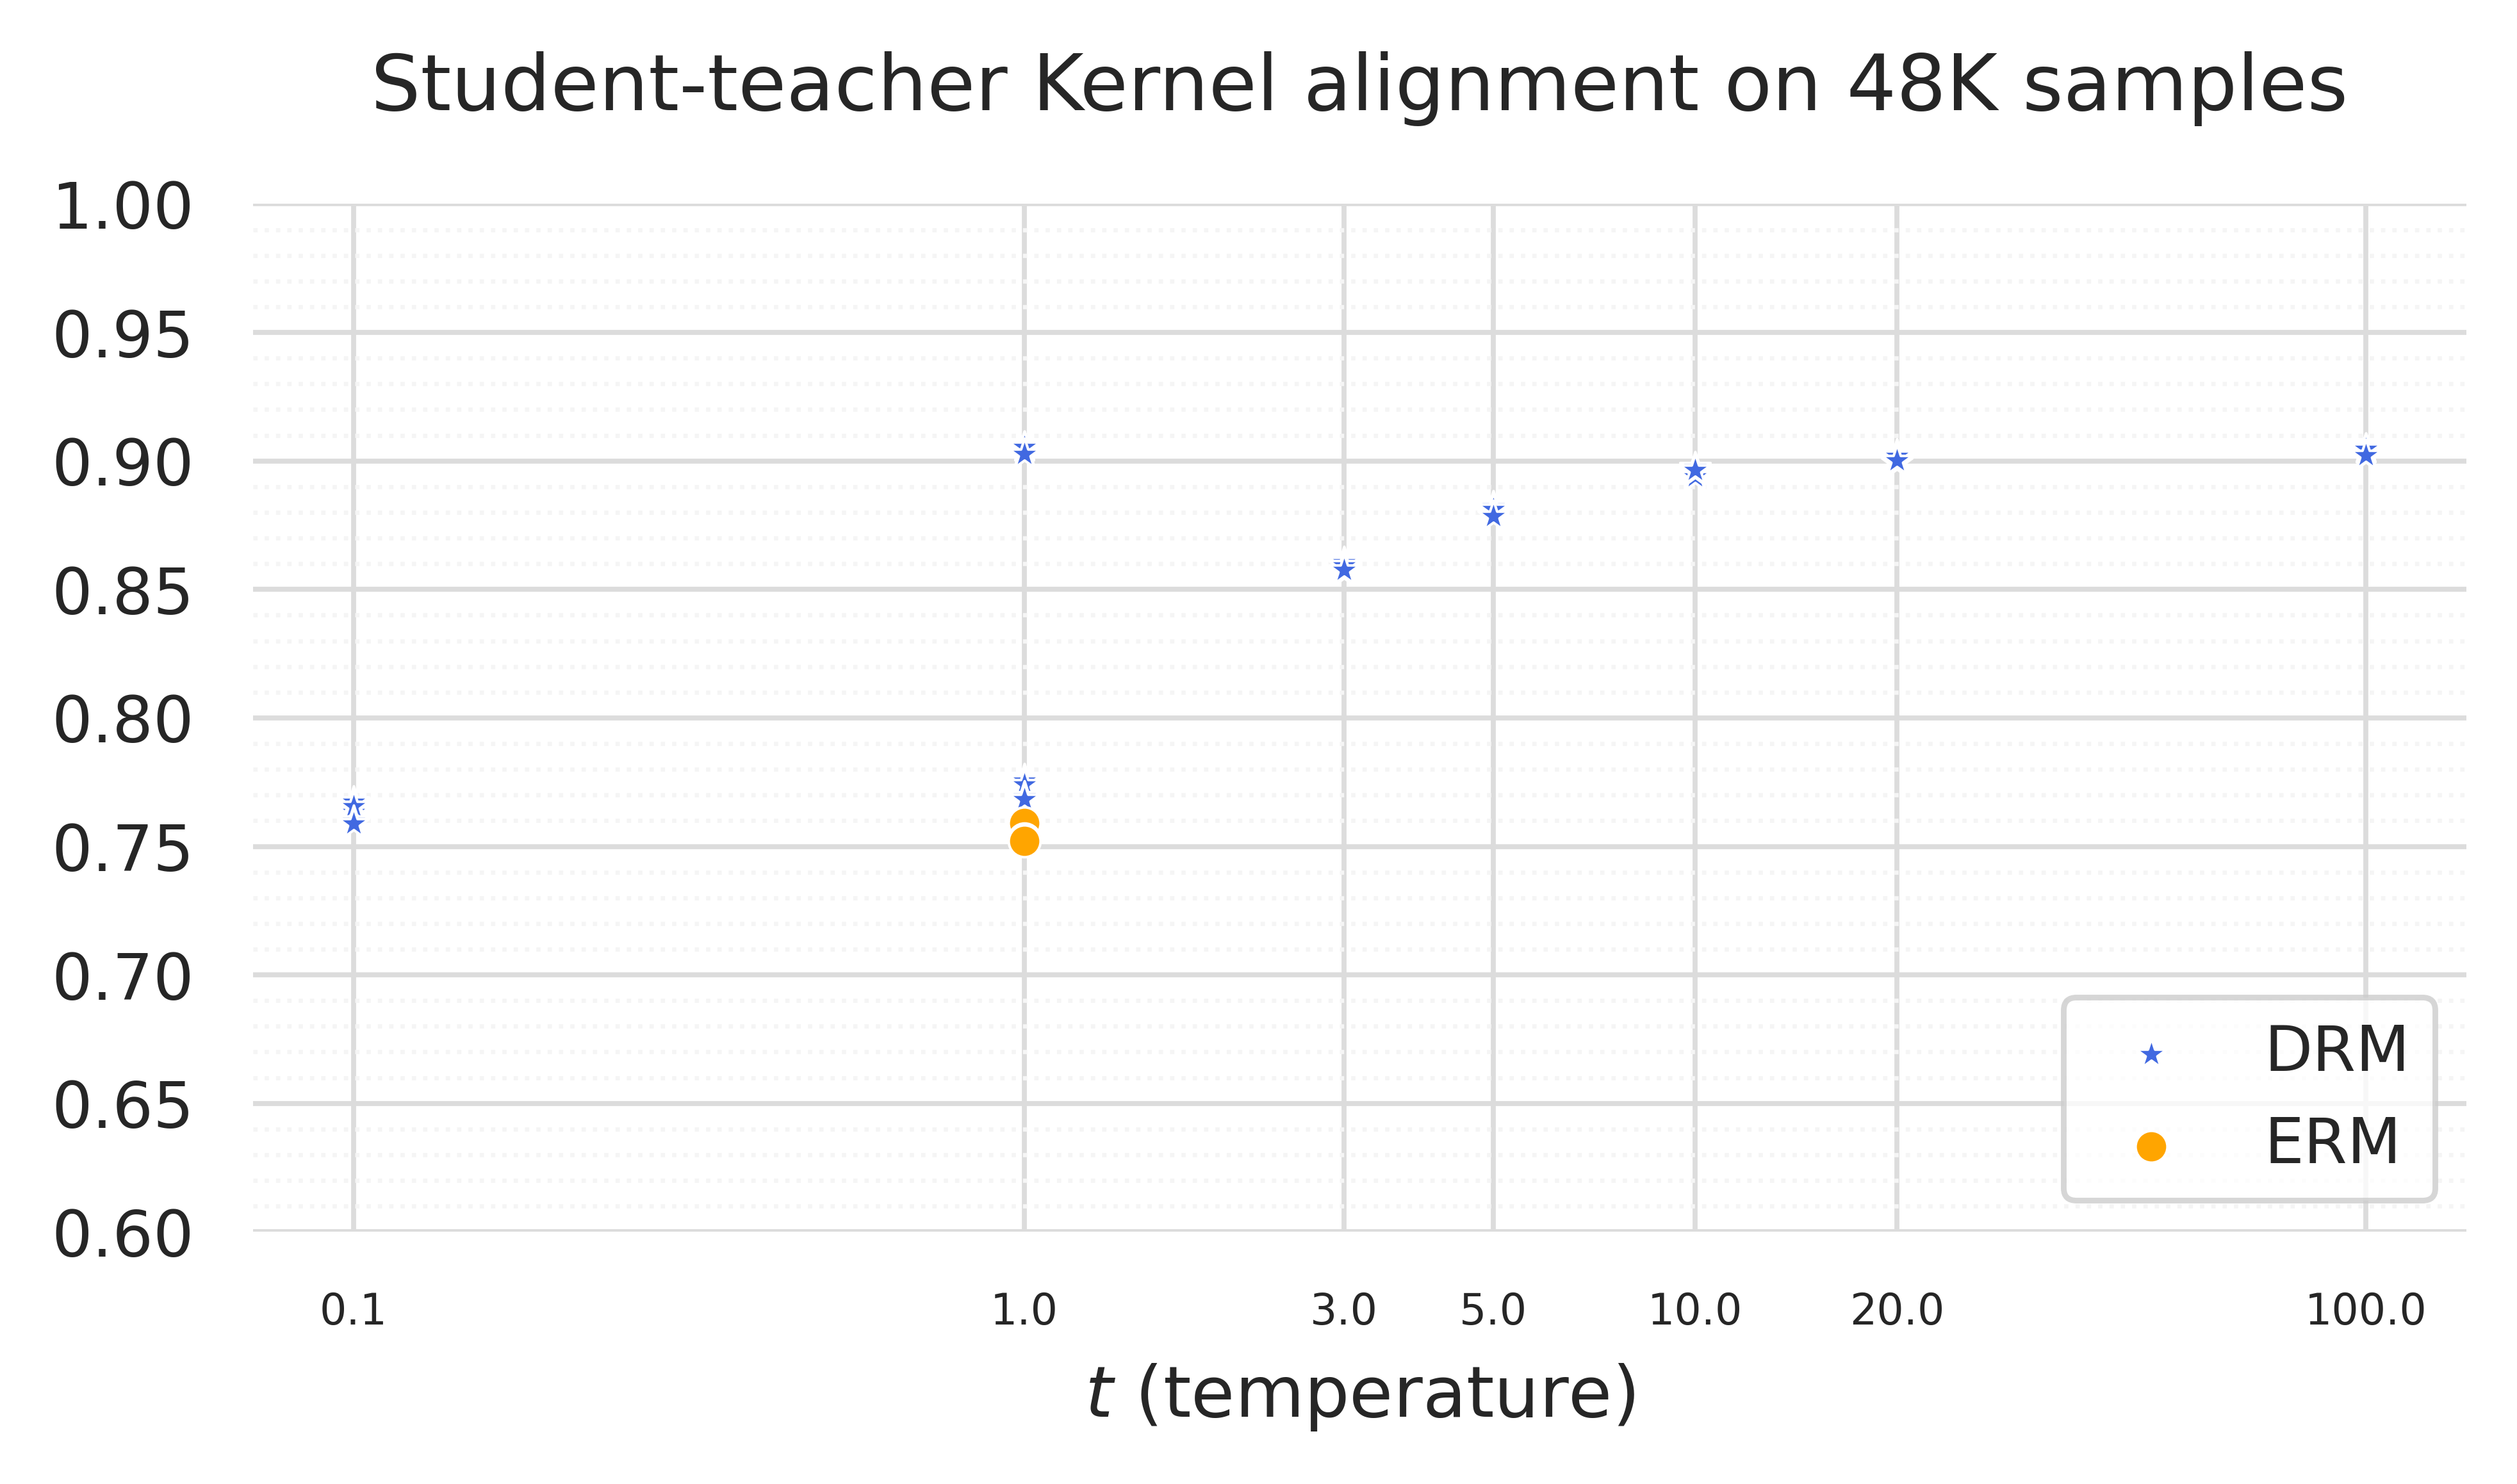

In [6]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray', 'purple', 'slateblue']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.scatterplot(data=_df, x="temperature", y="final_cka_train", marker='*', 
                    color=colors[0], s=40, ax=ax, label="distil.val")

    _df = working_df.loc[working_df['alpha']==1.0]

    sns.scatterplot(data=_df, x="temperature", y="final_cka_train", s=40,
                markers=True, marker='o', color=colors[1], ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    ax.set_ylim([0.6,1.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(temperatures)
    ax.set_xticklabels(temperatures, fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Student-teacher Kernel alignment on 48K samples", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$t$ (temperature)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'DRM',
                  r'ERM'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()

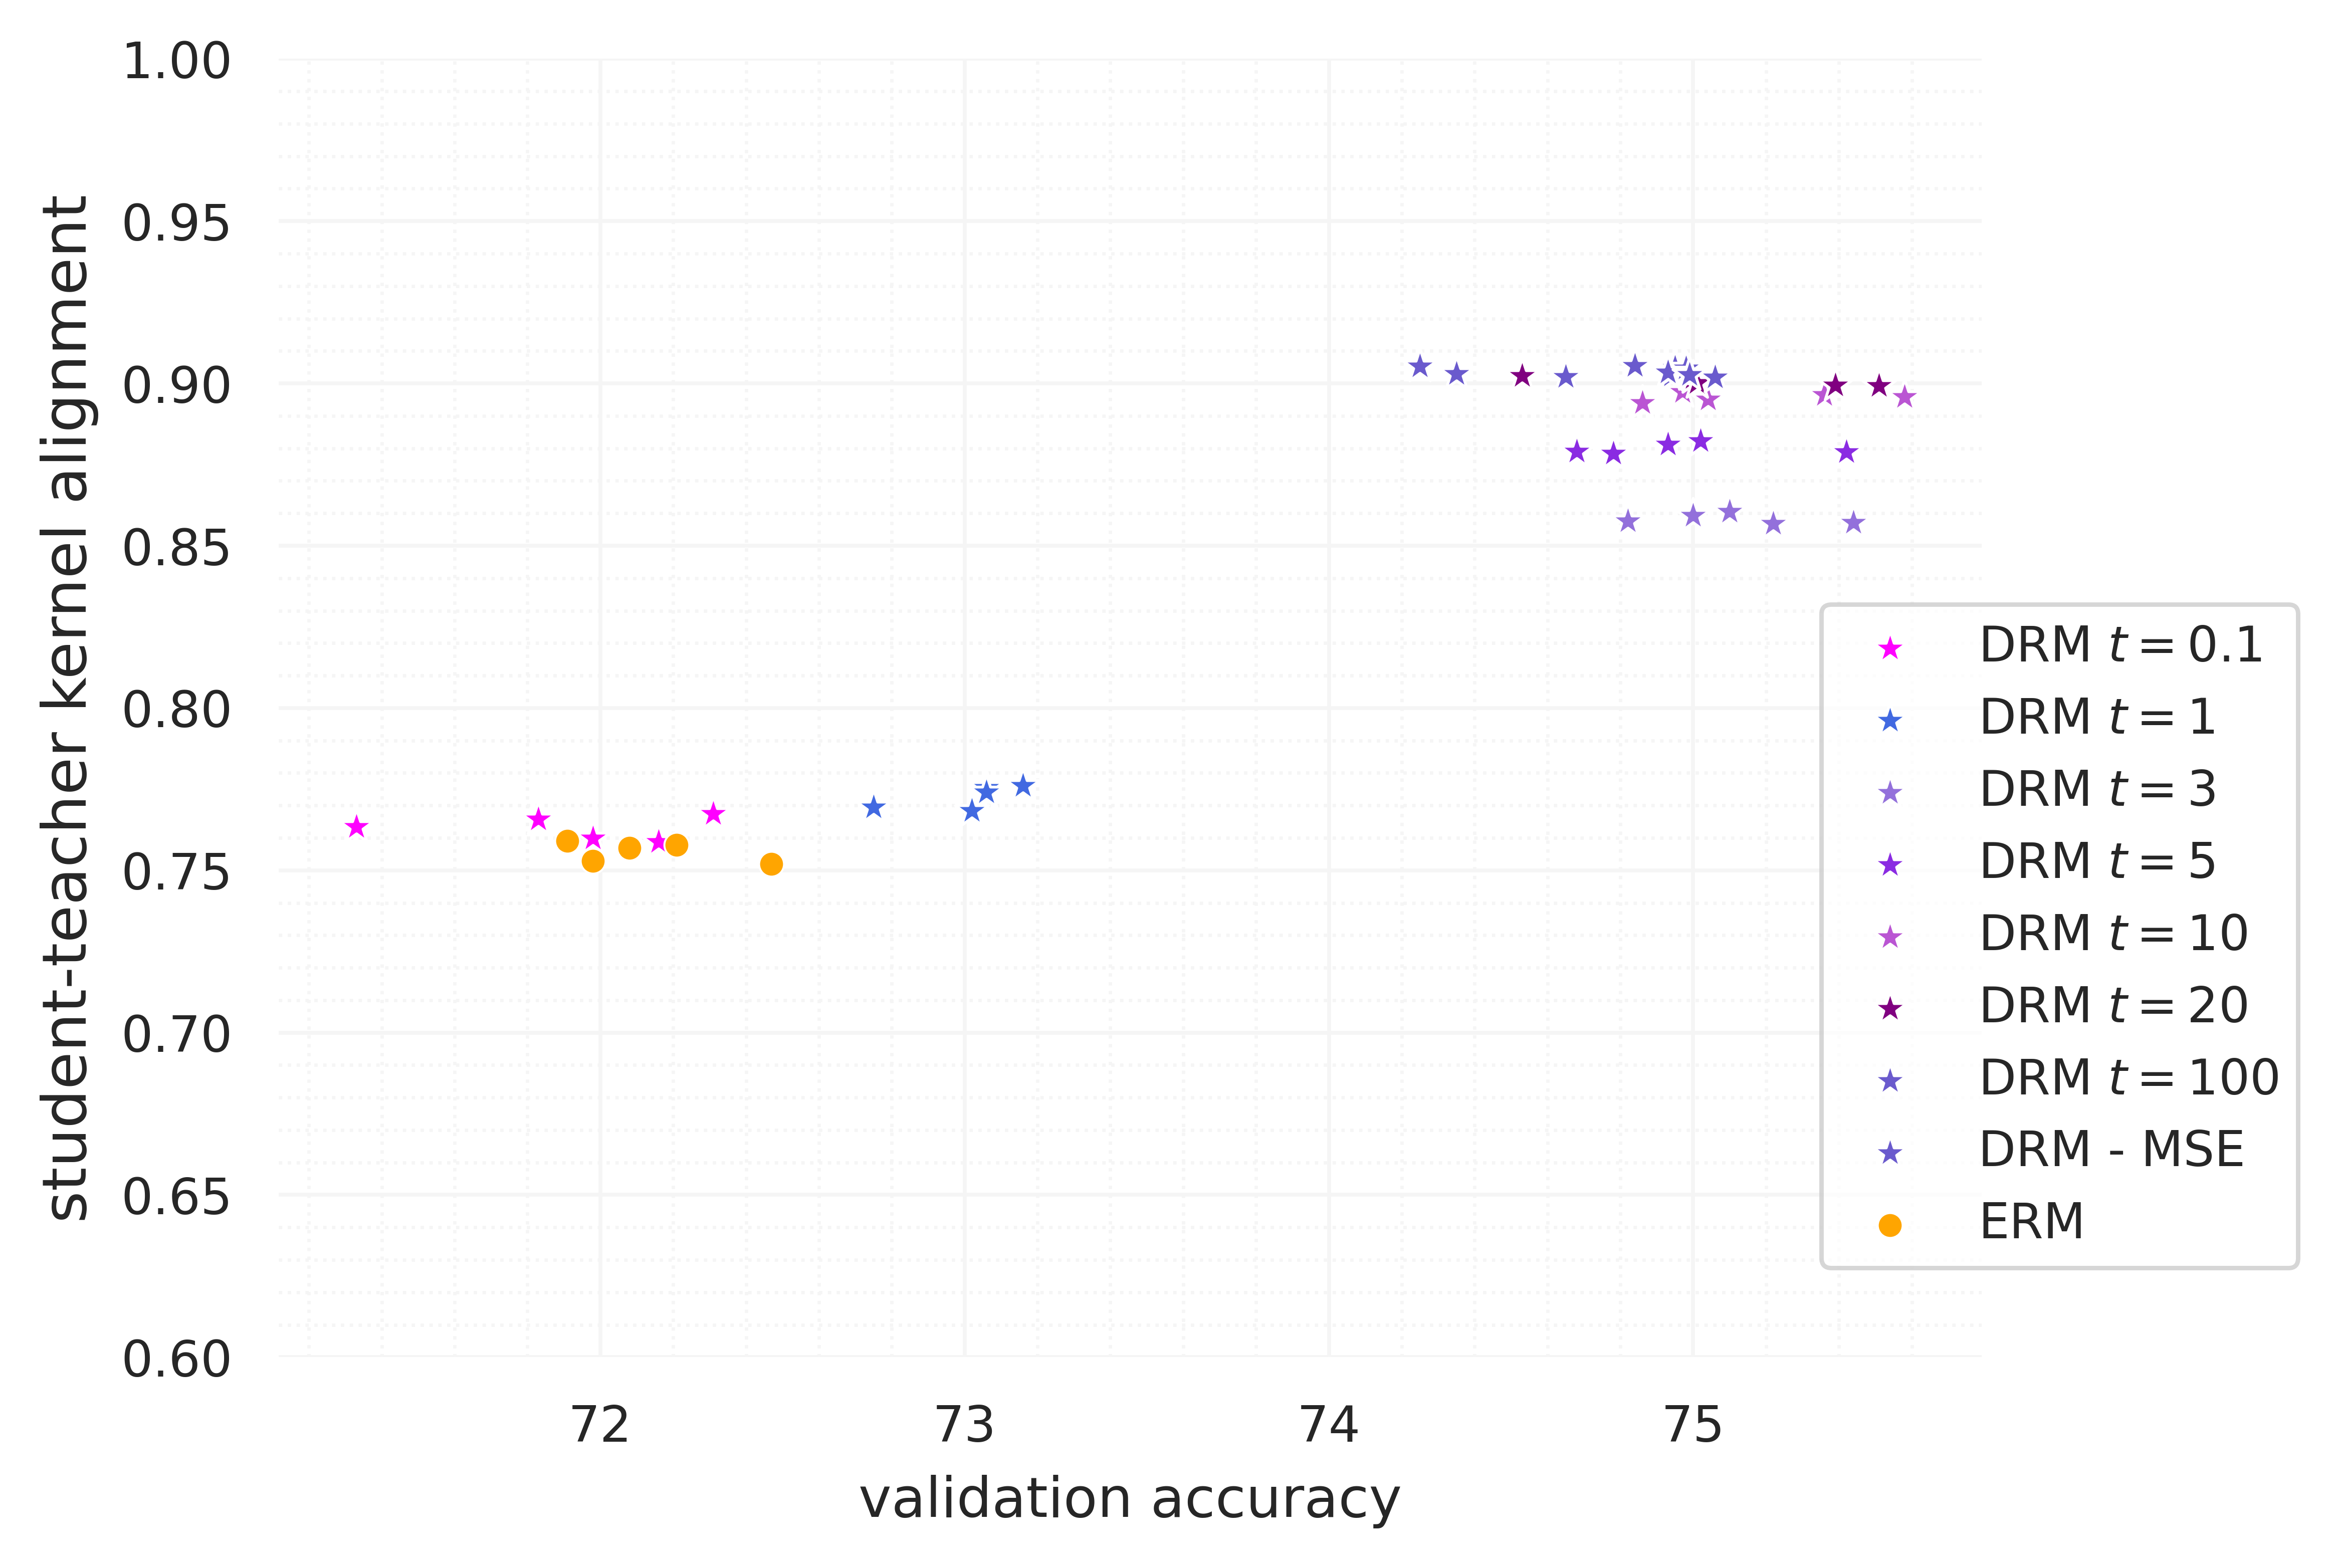

In [18]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray', 'purple', 'mediumorchid','blueviolet','mediumpurple', 'slateblue','darkmagenta','magenta','cyan']
    buffer_size = 48000

    _df = working_df.loc[working_df['alpha']==0.0].loc[working_df['buffer_size']==buffer_size]
    _df2 = _df.loc[_df['temperature']==0.1][:26]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[9], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['temperature']==1]
    _df2 = _df2.loc[_df2['MSE']==False]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[0], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['temperature']==3]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[6], s=40, ax=ax, label="distil.val")
  
    
    _df2 = _df.loc[_df['temperature']==5]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[5], s=40, ax=ax, label="distil.val")
    

    _df2 = _df.loc[_df['temperature']==10]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[4], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['temperature']==20]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[3], s=40, ax=ax, label="distil.val")
    

    _df2 = _df.loc[_df['temperature']==100]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[7], s=40, ax=ax, label="distil.val")
    
    _df2 = _df.loc[_df['MSE']==True]
    sns.scatterplot(data=_df2, x="final_val_acc_S", y="final_cka_train", marker='*',
                    color=colors[7], s=40, ax=ax, label="distil.val")
    

    _df = working_df.loc[working_df['alpha']==1.0].loc[working_df['buffer_size']==buffer_size]
    sns.scatterplot(data=_df, x="final_val_acc_S", y="final_cka_train", s=20, 
                markers=True, marker='o', color=colors[1], ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    ax.set_ylim([0.6,1.0])

    ax.tick_params(axis='both',  labelsize=9)
    #ax.set_xticks(temperatures)
    #ax.set_xticklabels(temperatures, fontsize=6)
    #ax.tick_params(axis='x',  rotation=0)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    #ax.set_title(f"Student-teacher Kernel alignment VS Validation accuracyon 48K samples", fontsize=11, y=1.05)
    ax.set_ylabel(r'student-teacher kernel alignment', fontsize=11, x=-0.2)
    ax.set_xlabel(r'validation accuracy', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'DRM $t=0.1$',
                  r'DRM $t=1$',
                  r'DRM $t=3$',
                  r'DRM $t=5$',
                  r'DRM $t=10$',
                  r'DRM $t=20$',
                  r'DRM $t=100$',
                  r'DRM - MSE',
                  r'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right",
                bbox_to_anchor=(1.2, 0.05))


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='whitesmoke', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()

In [94]:
working_df.loc[working_df['MSE']==True,'temperature'] = 'MSE'
working_df['T']= working_df['temperature'].astype('category')


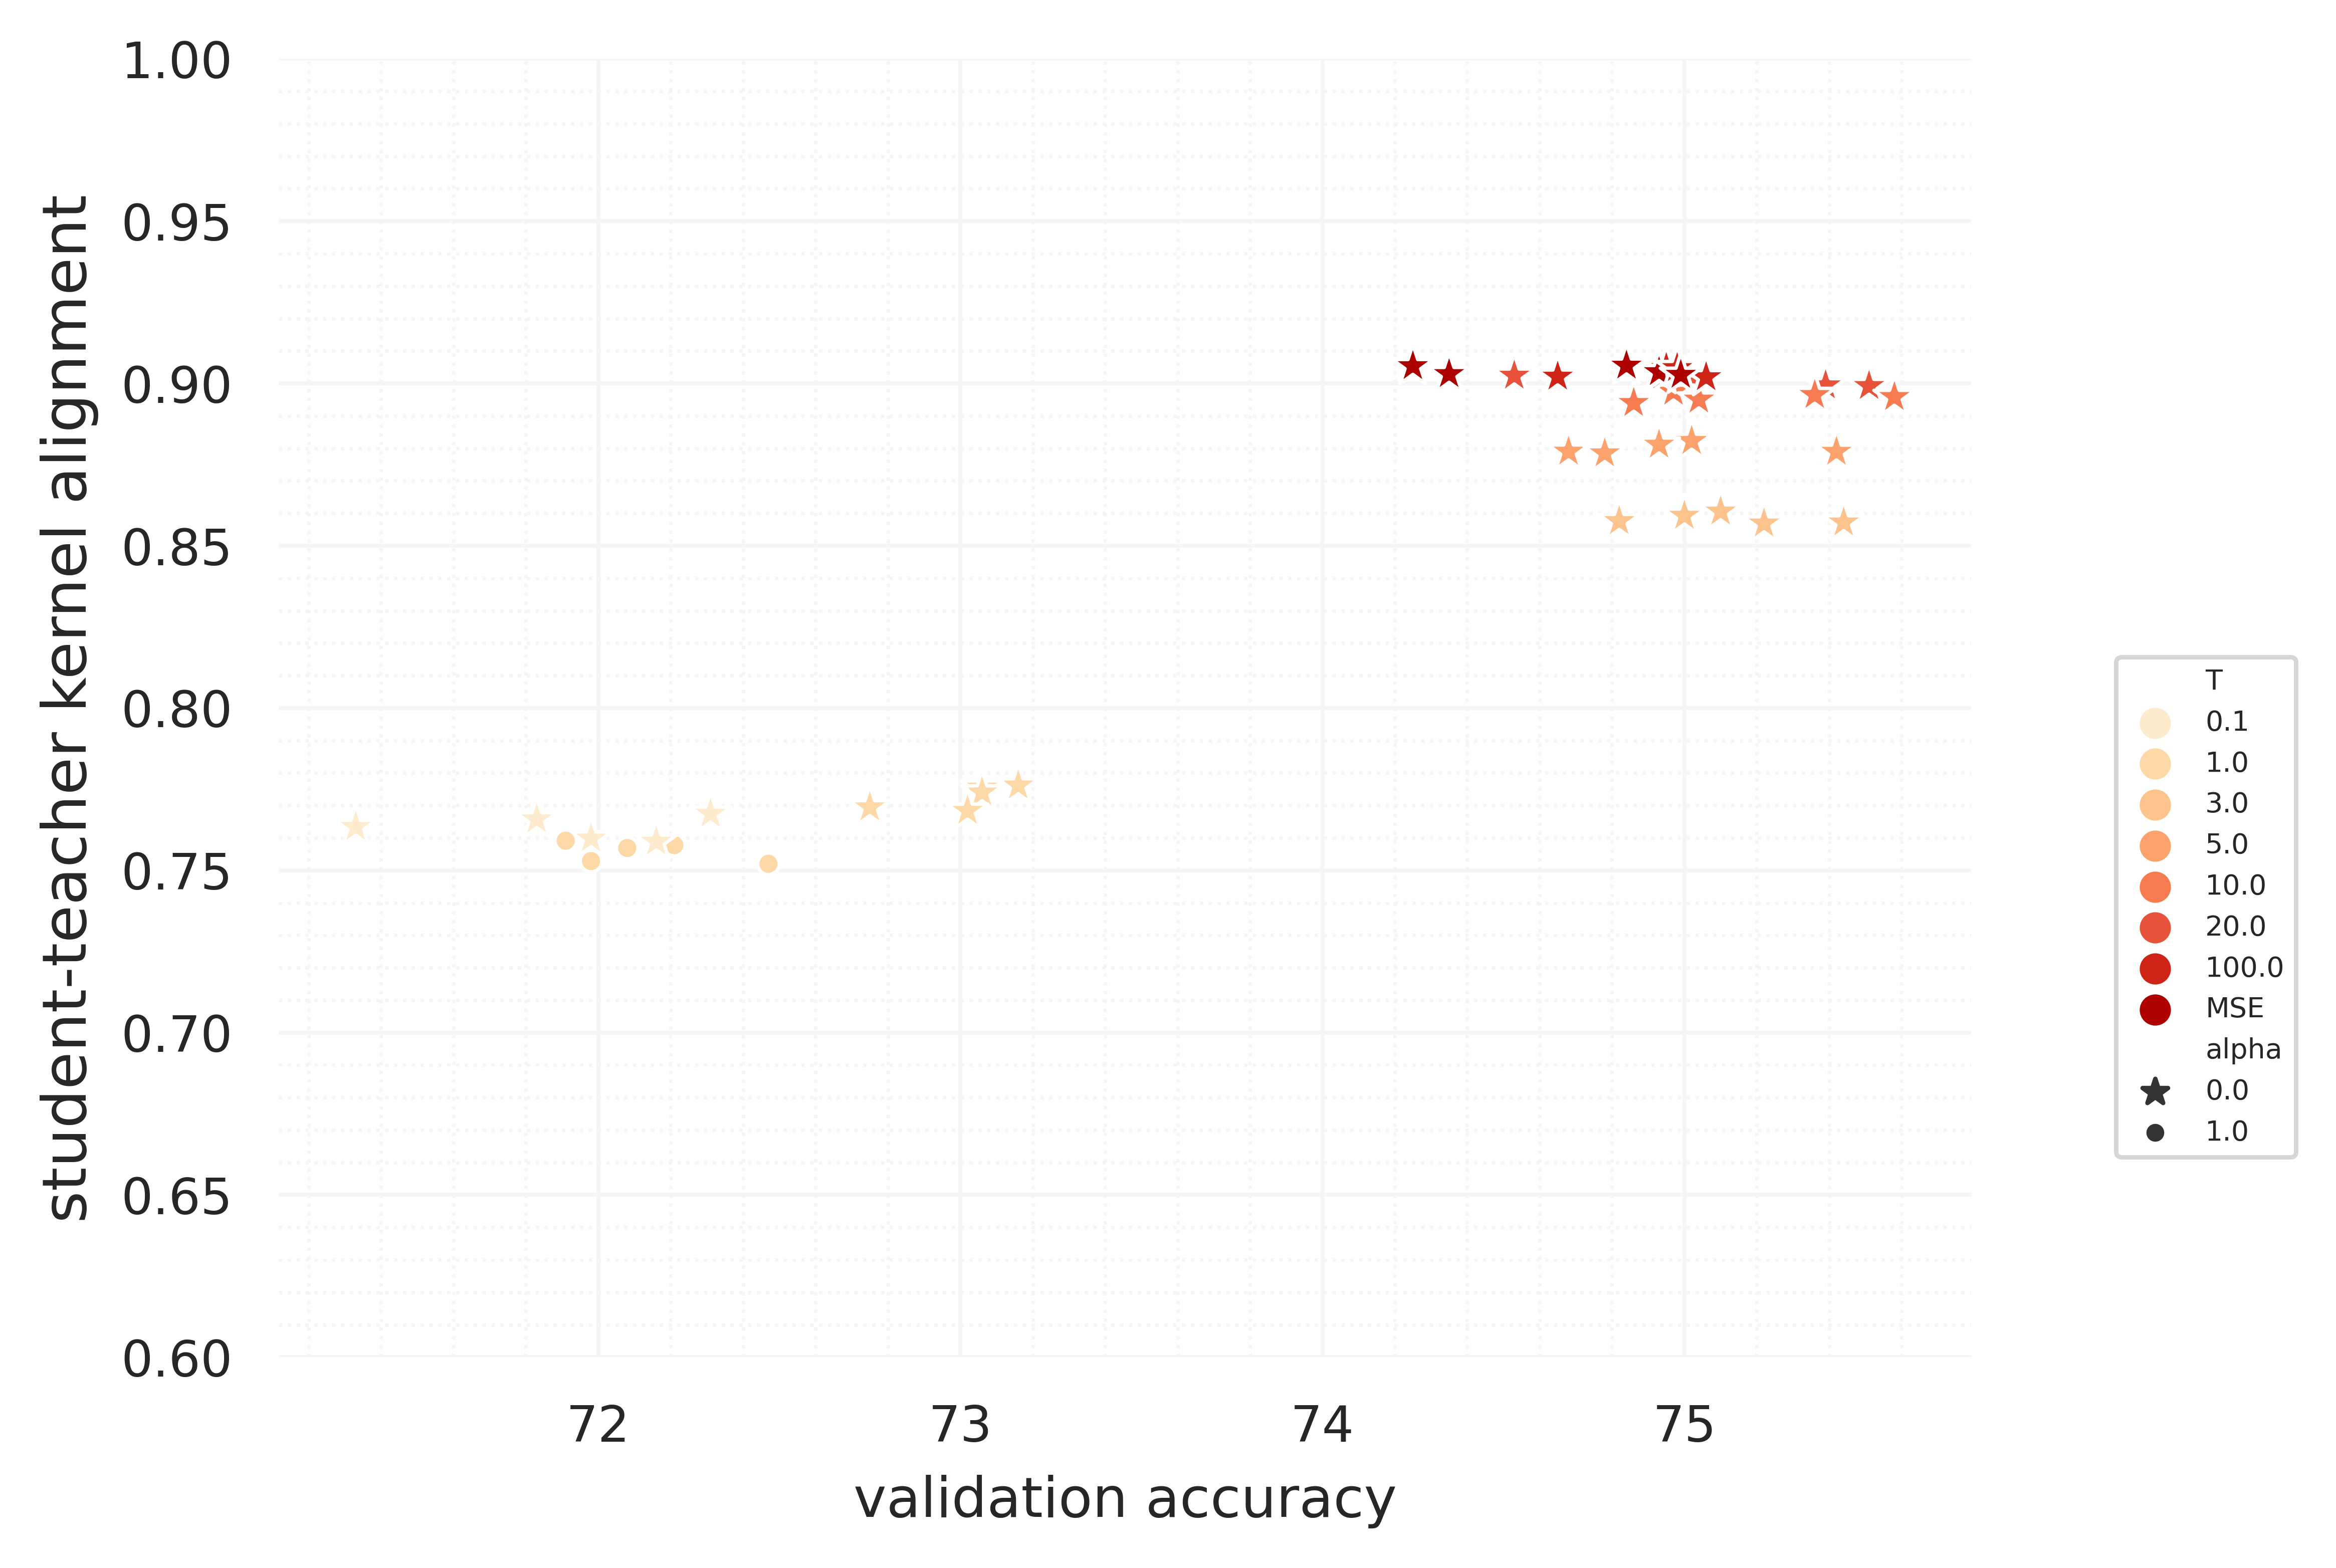

In [95]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(6,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray', 'purple', 'mediumorchid','blueviolet','mediumpurple', 'slateblue','darkmagenta','magenta','cyan']
    buffer_size=48000

    _df = working_df.loc[working_df['buffer_size']==buffer_size]
    sns.scatterplot(data=_df, x="final_val_acc_S", y="final_cka_train", s=60, 
                markers=['*','.'], hue='T', style='alpha', ax=ax, palette="OrRd")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    ax.set_ylim([0.6,1.0])

    ax.tick_params(axis='both',  labelsize=9)
    #ax.set_xticks(temperatures)
    #ax.set_xticklabels(temperatures, fontsize=6)
    #ax.tick_params(axis='x',  rotation=0)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    #ax.set_title(f"Student-teacher Kernel alignment VS Validation accuracyon 48K samples", fontsize=11, y=1.05)
    ax.set_ylabel(r'student-teacher kernel alignment', fontsize=11, x=-0.2)
    ax.set_xlabel(r'validation accuracy', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    # ax.legend(h, [r'DRM $t=0.1$',
    #               r'DRM $t=1$',
    #               r'DRM $t=3$',
    #               r'DRM $t=5$',
    #               r'DRM $t=10$',
    #               r'DRM $t=20$',
    #               r'DRM $t=100$',
    #               r'DRM - MSE',
    #               r'ERM'], 
    #             title="", ncol=1, loc="lower right",
    #             bbox_to_anchor=(1.2, 0.05))
    ax.legend(bbox_to_anchor=(1.2, 0.55), fontsize=5)


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='whitesmoke', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()

### Cifar10

In [14]:
logs_path = './logs/results/cifar5m/CNN/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  checkpoints_stud  pretrained  optim_wd  \
0            no  0.1         True             False       False     0.001   
1            no  0.1         True             False       False     0.001   
2            no  0.1         True             False       False     0.001   
3            no  0.1         True             False       False     0.001   
4            no  0.1         True             False       False     0.001   
..          ...  ...          ...               ...         ...       ...   
410          no  0.1         True             False       False     0.001   
411          no  0.1         True             False       False     0.001   
412          no  0.1         True             False       False     0.001   
413          no  0.1         True             False       False     0.001   
414          no  0.1         True             False       False     0.001   

     optim_adam  optim_mom  optim_warmup  optim_nesterov  ...  network  \
0         False          0             5           False  ...      CNN   
1         False          0             5           False  ...      CNN   
2         False          0             5           False  ...      CNN   
3         False          0             5           False  ...      CNN   
4         False          0             5           False  ...      CNN   
..          ...        ...           ...             ...  ...      ...   
410       False          0             5           False  ...      CNN   
411       False          0             5           False  ...      CNN   
412       False          0             5           False  ...      CNN   
413       False          0             5           False  ...      CNN   
414       False          0             5           False  ...      CNN   

     buffer_train_time  final_train_acc_S  final_cka_train  final_cka_val  \
0           167.342772          71.916667         0.777416       0.729838   
1           169.271855          68.250000         0.778051       0.725233   
2           175.771911          74.333333         0.756099       0.708532   
3           169.743891          77.666667         0.435920       0.413524   
4           175.894903          72.083333         0.772081       0.720882   
..                 ...                ...              ...            ...   
410         645.691870          95.655000         0.868010       0.876512   
411         650.328598          95.638333         0.862218       0.874761   
412         694.781859          95.913333         0.873204       0.875953   
413         702.303657          95.847500         0.870163       0.870678   
414         712.507551          95.905833         0.868493       0.868295   

     final_val_acc_S final_train_agreement  final_val_agreement  \
0              58.88             73.000000                60.61   
1              57.90             70.000000                59.46   
2              61.21             76.583333                62.96   
3              42.26             87.000000                42.92   
4              59.76             74.000000                61.09   
..               ...                   ...                  ...   
410            86.99             87.603333                87.53   
411            86.79             87.640833                86.97   
412            87.30             87.551667                87.71   
413            86.79             87.485833                87.12   
414            86.76             87.530000                87.41   

    final_val_function_distance  final_distance_teacher_student  
0                      0.383379                       20.602783  
1                      0.399363                       20.434973  
2                      0.364599                       20.981312  
3                      0.706553                       19.447678  
4                      0.378616                       20.831684  
..                          ...                             ... 

In [15]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'checkpoints_stud', 'pretrained',
       'optim_wd', 'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'temperature', 'gpus_id', 'seed', 'notes',
       'non_verbose', 'disable_log', 'validation', 'ignore_other_metrics',
       'debug_mode', 'nowand', 'wandb_entity', 'wandb_project', 'wandb_name',
       'buffer_size', 'minibatch_size', 'alpha', 'MSE', 'distillation_type',
       'K', 'C', 'gamma', 'final_val_acc_D', 'network', 'buffer_train_time',
       'final_train_acc_S', 'final_cka_train', 'final_cka_val',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student'],
      dtype='object')

In [16]:
working_df = res_df.dropna(axis=0, subset=['final_cka_train'])
#working_df = working_df.loc[work]
working_df['T']= working_df['temperature']
working_df.loc[working_df['MSE']==True,'T'] = 'MSE'
working_df['T']=working_df['T'].astype('category')
working_df['data_size']= working_df['buffer_size'].astype('category')
working_df['buffer_size_p'] = working_df['buffer_size']/60000


working_df

distributed   lr  checkpoints  checkpoints_stud  pretrained  optim_wd  \
0            no  0.1         True             False       False     0.001   
1            no  0.1         True             False       False     0.001   
2            no  0.1         True             False       False     0.001   
3            no  0.1         True             False       False     0.001   
4            no  0.1         True             False       False     0.001   
..          ...  ...          ...               ...         ...       ...   
410          no  0.1         True             False       False     0.001   
411          no  0.1         True             False       False     0.001   
412          no  0.1         True             False       False     0.001   
413          no  0.1         True             False       False     0.001   
414          no  0.1         True             False       False     0.001   

     optim_adam  optim_mom  optim_warmup  optim_nesterov  ...  \
0         False          0             5           False  ...   
1         False          0             5           False  ...   
2         False          0             5           False  ...   
3         False          0             5           False  ...   
4         False          0             5           False  ...   
..          ...        ...           ...             ...  ...   
410       False          0             5           False  ...   
411       False          0             5           False  ...   
412       False          0             5           False  ...   
413       False          0             5           False  ...   
414       False          0             5           False  ...   

     final_cka_train  final_cka_val  final_val_acc_S  final_train_agreement  \
0           0.777416       0.729838            58.88              73.000000   
1           0.778051       0.725233            57.90              70.000000   
2           0.756099       0.708532            61.21              76.583333   
3           0.435920       0.413524            42.26              87.000000   
4           0.772081       0.720882            59.76              74.000000   
..               ...            ...              ...                    ...   
410         0.868010       0.876512            86.99              87.603333   
411         0.862218       0.874761            86.79              87.640833   
412         0.873204       0.875953            87.30              87.551667   
413         0.870163       0.870678            86.79              87.485833   
414         0.868493       0.868295            86.76              87.530000   

     final_val_agreement  final_val_function_distance  \
0                  60.61                     0.383379   
1                  59.46                     0.399363   
2                  62.96                     0.364599   
3                  42.92                     0.706553   
4                  61.09                     0.378616   
..                   ...                          ...   
410                87.53                     0.141009   
411                86.97                     0.142887   
412                87.71                     0.140283   
413                87.12                     0.143519   
414                87.41                     0.141274   

    final_distance_teacher_student      T data_size  buffer_size_p  
0                        20.602783   20.0      1200           0.02  
1                        20.434973  100.0      1200           0.02  
2                        20.981312    5.0      1200           0.02  
3                        19.447678    0.1      1200           0.02  
4                        20.831684   10.0      1200           0.02  
..                             ...    ...       ...            ...  
410                      21.231546    1.0    120000           2.00  
411                      20.986753    1.0    120000           2.00  
412                      21.081181    1.0  

In [17]:
working_df['buffer_size'].unique()

array([  1200,   6000,  12000,  24000,  60000, 120000, 600000])

In [18]:
temperatures = sorted(list(working_df['temperature'].unique()))
temperatures

[0.1, 1.0, 3.0, 5.0, 10.0, 20.0, 100.0]

In [19]:
buffer_sizes_p = sorted(list(working_df['buffer_size_p'].unique()))
buffer_sizes_p

[0.02, 0.1, 0.2, 0.4, 1.0, 2.0, 10.0]

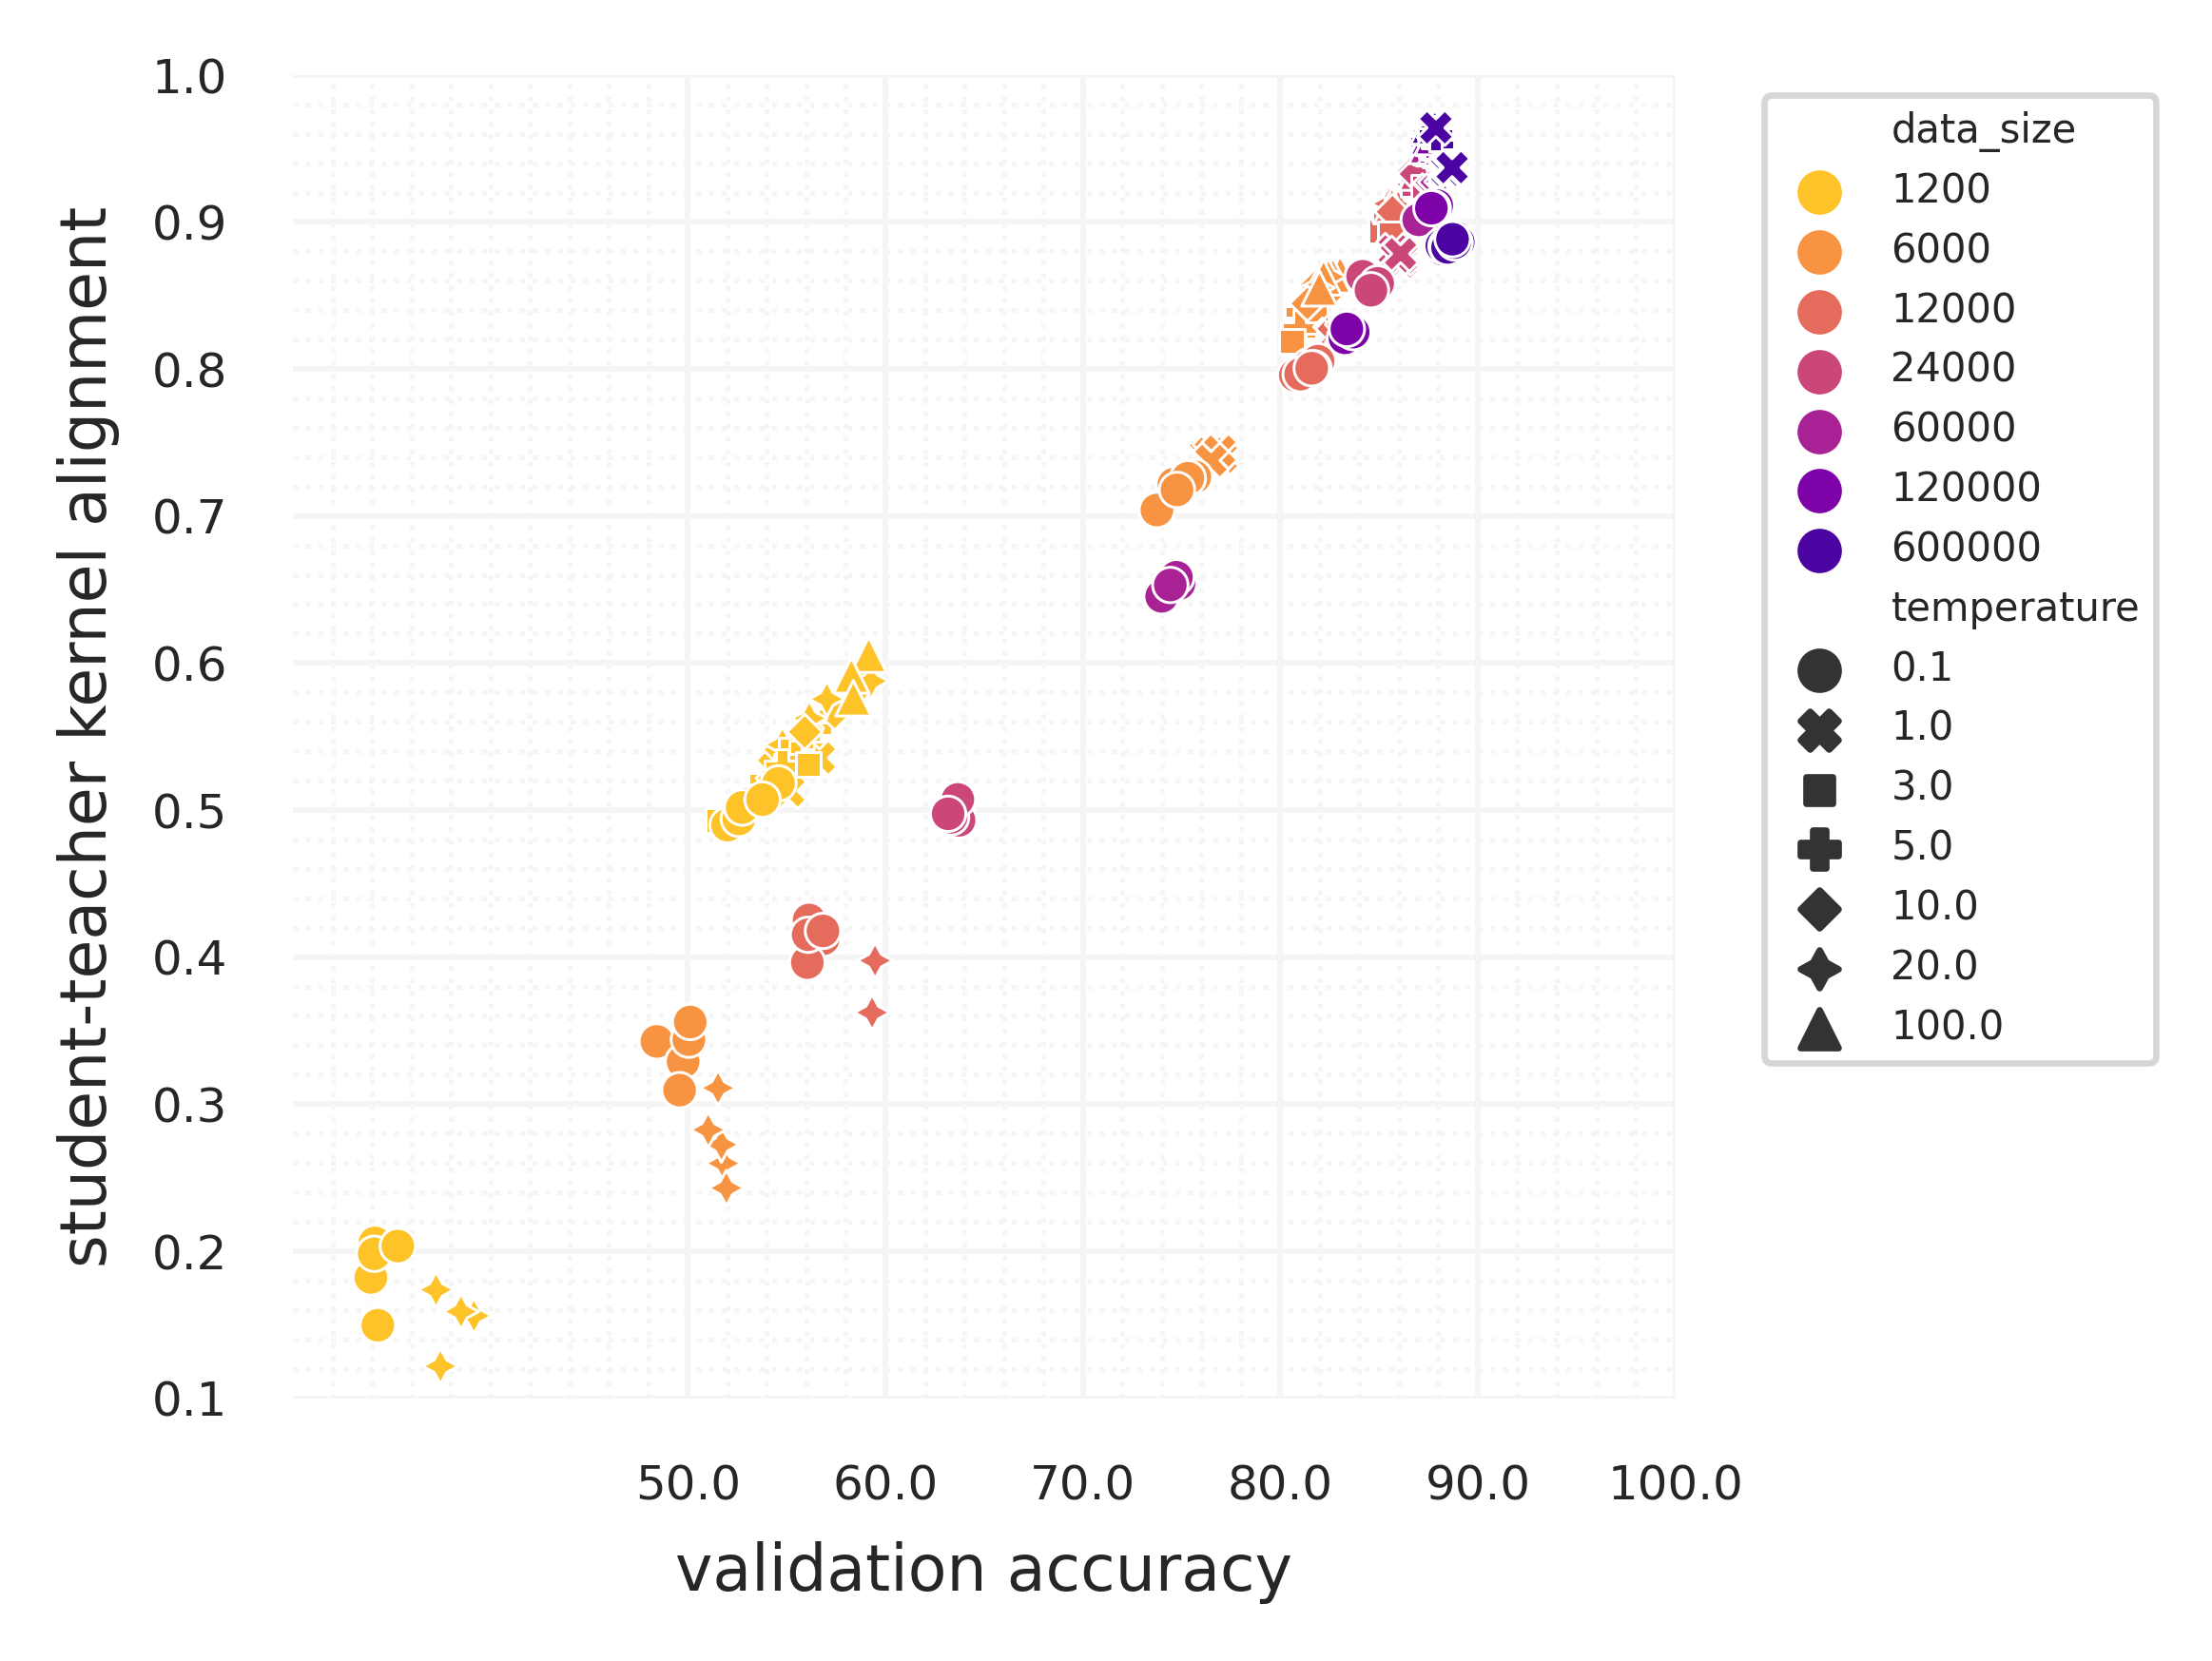

In [9]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(4,3), sharey=True, dpi=600)
    colors = ['royalblue','orange','dimgray', 'purple', 'mediumorchid','blueviolet','mediumpurple', 'slateblue','darkmagenta','magenta','cyan']
    buffer_size=120000

    _df = working_df.loc[working_df['alpha']==0]#.loc[working_df['buffer_size']==buffer_size]
    sns.scatterplot(data=_df, x="final_val_acc_S", y="final_cka_val", s=20, 
                marker='o', style='temperature', hue='data_size', ax=ax, palette="plasma_r")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    ax.set_xlim([30,100])
    ax.set_ylim([0.1,1.0])

    ax.tick_params(axis='both',  labelsize=6)
    xticks  = [50., 60.0, 70., 80., 90., 100.0]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=6)
    #ax.tick_params(axis='x',  rotation=0)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    #ax.set_title(f"Student-teacher Kernel alignment VS Validation accuracyon 48K samples", fontsize=11, y=1.05)
    ax.set_ylabel(r'student-teacher kernel alignment', fontsize=8, x=-0.2)
    ax.set_xlabel(r'validation accuracy', fontsize=8, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    # ax.legend(h, [r'DRM $t=0.1$',
    #               r'DRM $t=1$',
    #               r'DRM $t=3$',
    #               r'DRM $t=5$',
    #               r'DRM $t=10$',
    #               r'DRM $t=20$',
    #               r'DRM $t=100$',
    #               r'DRM - MSE',
    #               r'ERM'], 
    #             title="", ncol=1, loc="lower right",
    #             bbox_to_anchor=(1.2, 0.05))
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize=5)


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='whitesmoke', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()

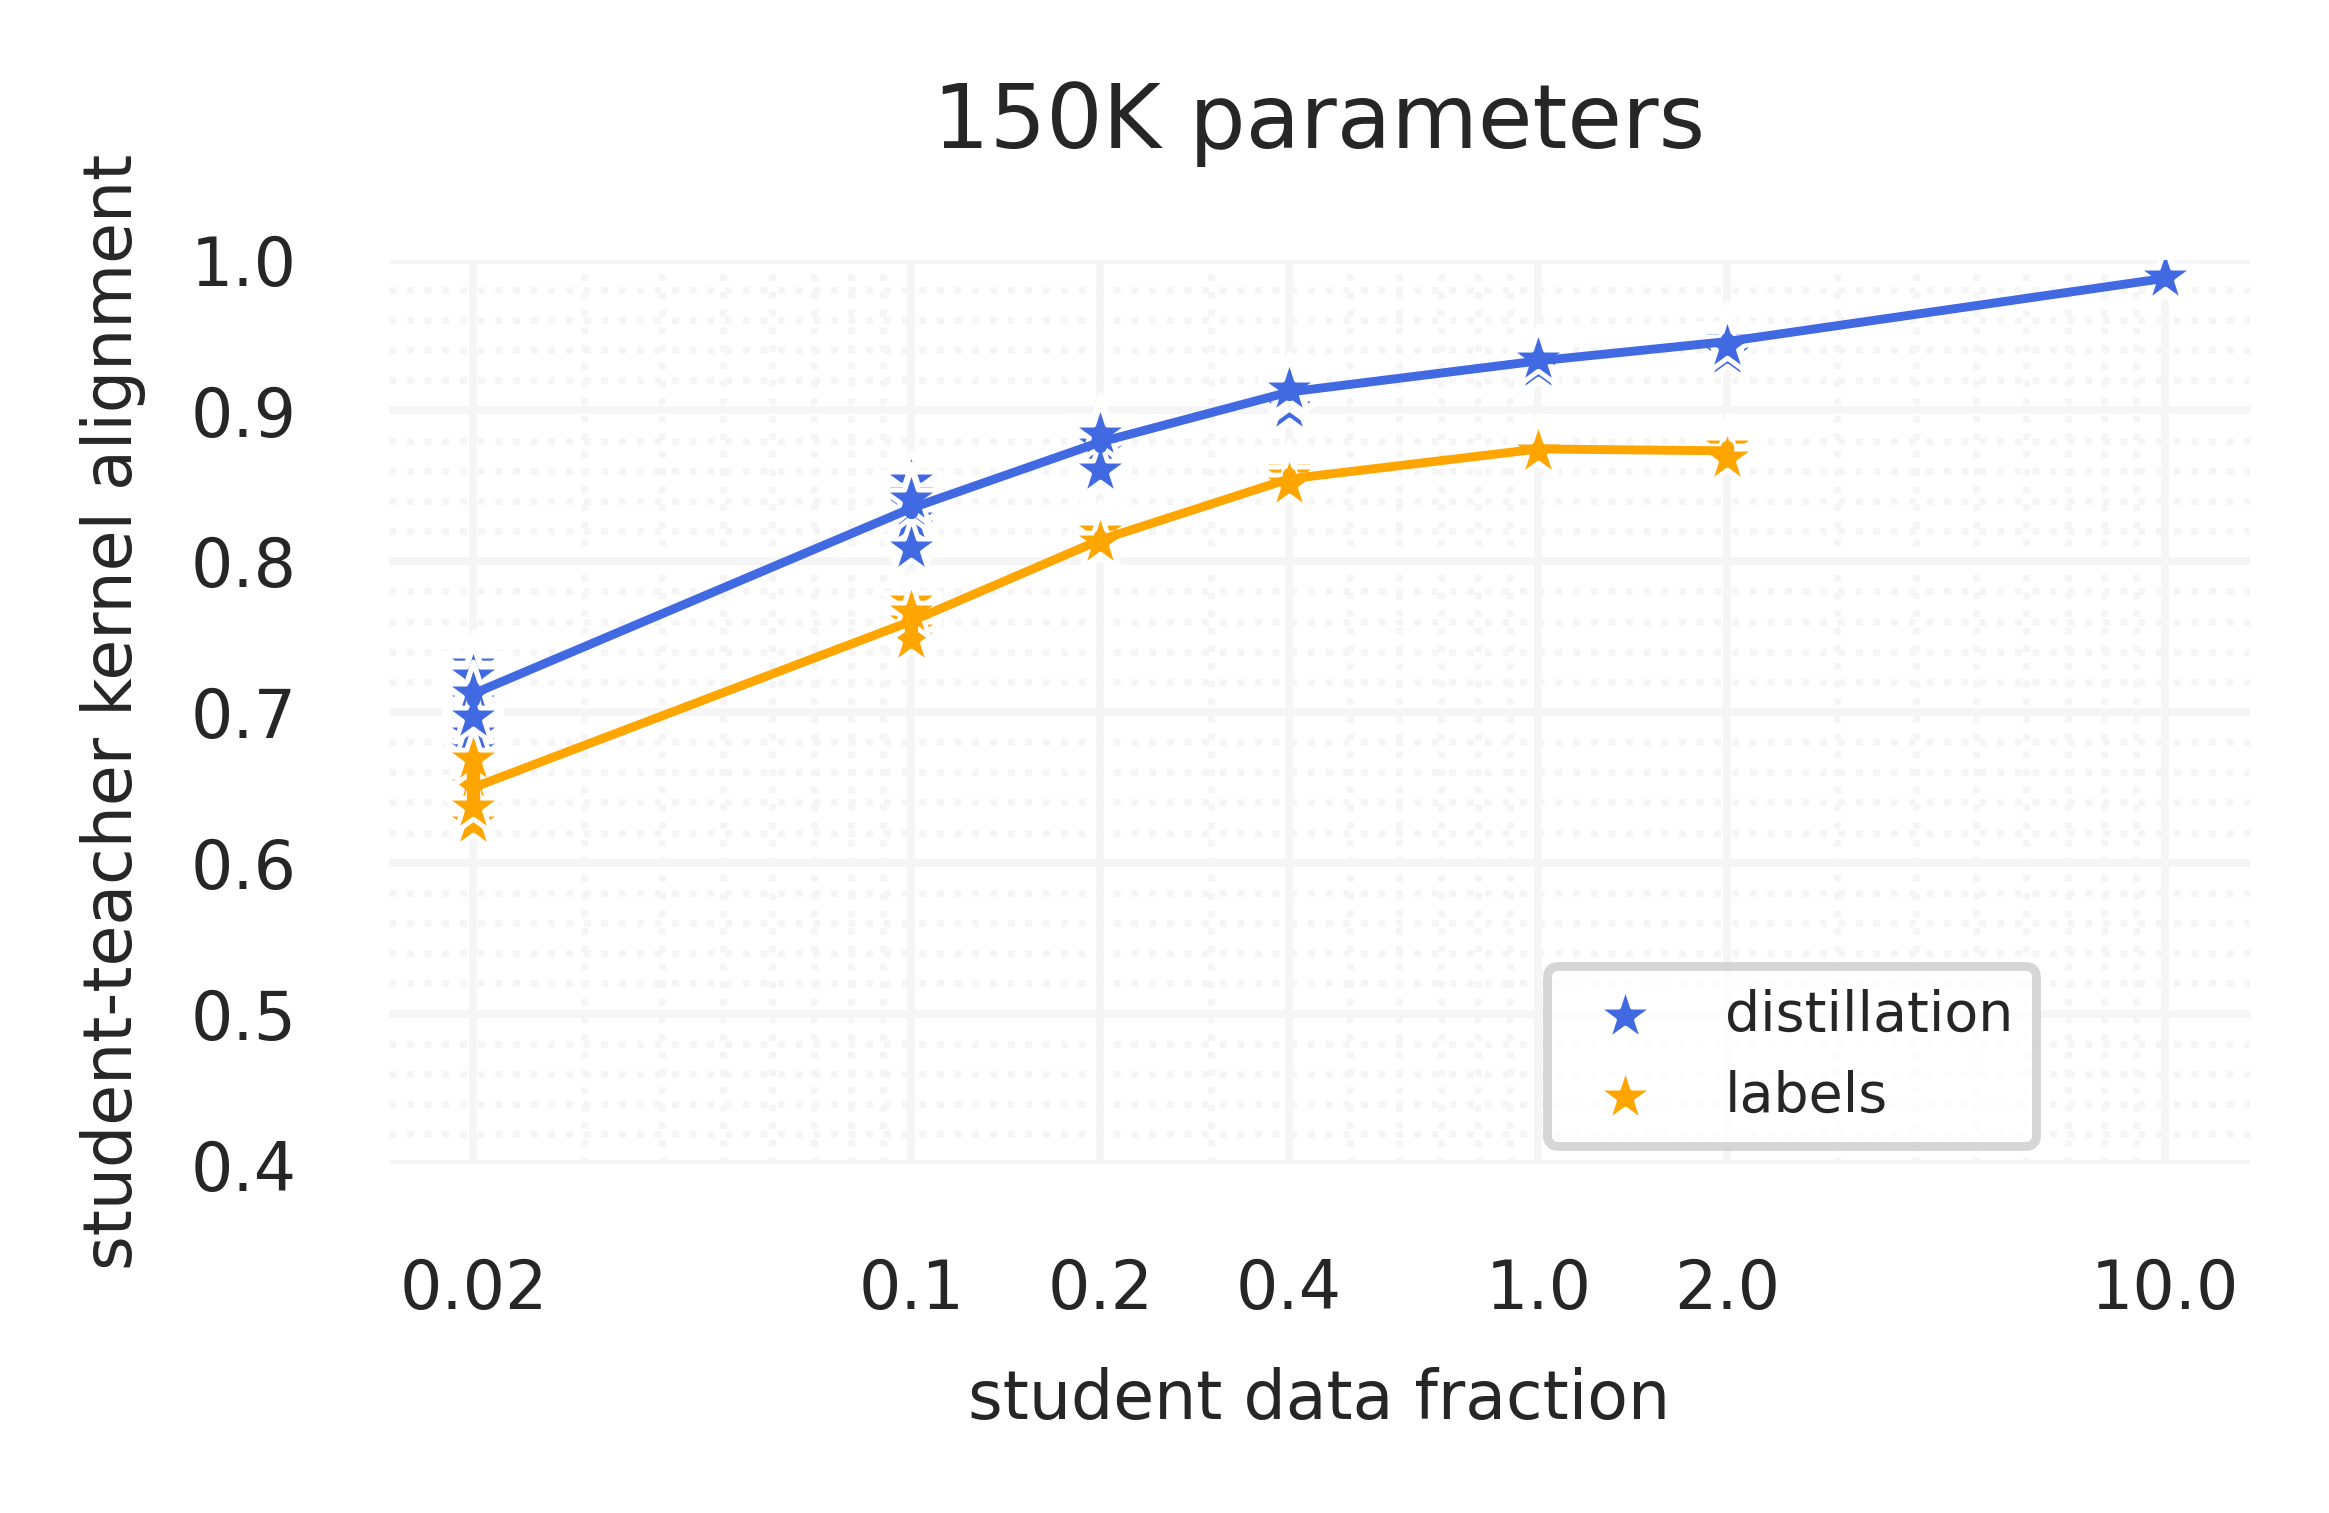

In [22]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(3,2), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray', 'purple', 'mediumorchid','blueviolet','mediumpurple', 'slateblue','darkmagenta','magenta','cyan']
    buffer_size=120000

    # sns.scatterplot(data=_df, x="buffer_size", y="final_cka_val", s=20, 
    #             marker='.', size='temperature', hue='alpha', ax=ax, palette="plasma_r")
    # sns.lmplot(data=_df, x="buffer_size", y="final_cka_val", hue='alpha', palette="plasma_r", logx=True)
    _df = working_df

    _df0 = _df.loc[_df['alpha']==0]#.loc[_df['asymmetric_temperature'].isna()]
    _df0A = _df0.loc[_df0['temperature']>1]
    _df0B = _df0.loc[_df0['temperature']<=1]
    # sns.scatterplot(data=_df0B, x="buffer_size", y="final_cka_train", s=10, 
    #             marker='.', style='asymmetric_temperature', color=colors[5], ax=ax)
    sns.lineplot(data=_df0A, x="buffer_size_p", y="final_cka_val", linewidth=0.8, 
                 markersize=0, errorbar='ci', err_style='bars',
                color=colors[0], ax=ax, label="")    
    sns.scatterplot(data=_df0A, x="buffer_size_p", y="final_cka_val", s=30, 
                marker='*', color=colors[0], ax=ax, label="drm")
    # sns.regplot(data=_df0, x="buffer_size", y="final_cka_val", ax=ax, color=colors[0], 
    #             scatter=False, line_kws={'linewidth':1}, logx=True, x_jitter=.55,
    #              ci=None)
    _df1 = _df.loc[_df['alpha']==1]
    sns.lineplot(data=_df1, x="buffer_size_p", y="final_cka_val", linewidth=0.8,
                 markersize=0,errorbar='ci',err_style='bars',
                color=colors[1], ax=ax, label="")
    sns.scatterplot(data=_df1, x="buffer_size_p", y="final_cka_val", s=30,
                marker='*', color=colors[1], ax=ax, label="erm")
    # sns.regplot(data=_df1, x="buffer_size", y="final_cka_val", ax=ax, color=colors[1], line_kws={'linewidth':1},
    #               ci=None, scatter=False, logx=True, x_jitter=.55)

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,20.])
    #ax.set_xlim([50,100])
    ax.set_ylim([0.4,1.0])

    ax.tick_params(axis='both',  labelsize=6)
    #xticks  = [50., 60.0, 70., 80., 90., 100.0]
    xticks = buffer_sizes_p
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=6)
    #ax.tick_params(axis='x',  rotation=90)

    #yticks = [0.0, 25.0, 50.0, 75., 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    #ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"150K parameters", fontsize=8, y=1.05)
    ax.set_ylabel(r'student-teacher kernel alignment', fontsize=6, x=-0.2)
    ax.set_xlabel(r'student data fraction', fontsize=6, y=-1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'distillation',
                  r'labels'], 
                title="", ncol=1, fontsize=5,
                bbox_to_anchor=(0.9, 0.25))
    #ax.legend(h, [], bbox_to_anchor=(1.05, 1.0), fontsize=5)
    


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='whitesmoke', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    # a = ax.get_ygridlines()
    # b = a[3]
    # b.set_color('tab:olive')
    # b.set_linewidth(0.8)
    # b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()